**DATA SCIENCE - Spatial and Temporal Analysis of Rainfall and Vegetation Dynamics in Rwanda, 2000-2014**

In [1]:
#Import all necessary modules/libraries
from tabulate import tabulate
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from haversine import haversine , Unit
from scipy.optimize import curve_fit
import numpy as np
from tabulate import tabulate
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


**QUESTION 1 Data Preparation and Initial Loading for District-Level Rainfall and Vegetation Analysis**

Load the two historical monthly datasets for each of the thirty districts in Rwanda. The files
RwandaDistrictRainfall.csv and RwandaDistrictVegetation.csv provide measurements of
rainfall and the enhanced vegetation index obtained from satellite imagery.

In [2]:
#Load the data files
rwanda_rainfall = pd.read_csv('RwandaDistrictRainfall.csv', skiprows = 1)
rwanda_veg = pd.read_csv('RwandaDistrictVegetation.csv', skiprows = 1)
rwanda_lon_lat = pd.read_csv("RwandaDistrictCentroidsLongitude_Latitude.csv")

In [3]:
rwanda_rainfall = pd.read_csv('RwandaDistrictRainfall.csv', skiprows = 1)
rwanda_rainfall = rwanda_rainfall.rename(columns ={'Month':'District'})

In [4]:
#make copies of the dataframes 
rwanda_rainfall_df = rwanda_rainfall.copy()
rwanda_veg_df = rwanda_veg.copy()
rwanda_lon_lat_df = rwanda_lon_lat.copy()

In [5]:
rwanda_veg_df.columns

Index(['District', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG',
       'SEP',
       ...
       'MAR.14', 'APR.14', 'MAY.14', 'JUN.14', 'JUL.14', 'AUG.14', 'SEP.14',
       'OCT.14', 'NOV.14', 'DEC.14'],
      dtype='object', length=181)

In [6]:
rwanda_rainfall_df.columns

Index(['District', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG',
       'SEP',
       ...
       'MAR.14', 'APR.14', 'MAY.14', 'JUN.14', 'JUL.14', 'AUG.14', 'SEP.14',
       'OCT.14', 'NOV.14', 'DEC.14'],
      dtype='object', length=181)

In [7]:
rwanda_lon_lat_df.columns

Index(['wkt_geom', 'Prov_ID', 'Province', 'Dist_ID', 'District', 'Longitude',
       'Latitude'],
      dtype='object')

In [8]:
#check for missing values
rwanda_rainfall_df.isnull().sum().sum()

0

In [9]:
#check for missing values
rwanda_veg_df.isnull().sum().sum()


120

In [10]:
#Dropping missing values in vegetation data
rwanda_veg_df = rwanda_veg_df.dropna(axis = 1)


In [11]:
rwanda_veg_df.head(3)

,District,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,JAN.1,...,MAR.14,APR.14,MAY.14,JUN.14,JUL.14,AUG.14,SEP.14,OCT.14,NOV.14,DEC.14
0,Nyarugenge,127.133558,114.194658,97.707394,95.699328,88.729965,94.396226,126.312596,141.535903,124.094791,...,113.596873,133.532356,128.071603,116.118307,102.415884,98.550873,113.827449,119.234089,130.368276,119.310034
1,Gasabo,134.274365,121.746863,101.761017,96.821079,89.282895,96.753273,132.565069,144.322428,123.572873,...,115.230509,133.191208,131.875807,114.560526,98.387637,94.160935,113.132860,116.222577,129.540706,125.190370
2,Kicukiro,127.197642,112.709287,95.870810,93.065278,86.075767,90.362173,123.739127,146.537968,124.022534,...,112.664646,130.959094,126.141243,108.487588,96.017558,93.205589,107.235529,107.646784,127.485024,118.018397


In [12]:
rwanda_rainfall_df.head(2)

,District,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,...,MAR.14,APR.14,MAY.14,JUN.14,JUL.14,AUG.14,SEP.14,OCT.14,NOV.14,DEC.14
0,Nyarugenge,52.9,52.9,100.0,103.9,84.4,15.6,11.8,17.6,29.4,...,135.3,121.7,43.2,23.5,11.8,50.9,72.6,105.9,113.8,66.7
1,Gasabo,52.9,60.4,113.3,103.1,74.9,17.6,11.8,23.5,29.4,...,156.0,132.5,47.1,19.2,11.8,51.4,74.9,113.3,123.5,72.1


In [13]:
rwanda_veg_df.head(2)

,District,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,JAN.1,...,MAR.14,APR.14,MAY.14,JUN.14,JUL.14,AUG.14,SEP.14,OCT.14,NOV.14,DEC.14
0,Nyarugenge,127.133558,114.194658,97.707394,95.699328,88.729965,94.396226,126.312596,141.535903,124.094791,...,113.596873,133.532356,128.071603,116.118307,102.415884,98.550873,113.827449,119.234089,130.368276,119.310034
1,Gasabo,134.274365,121.746863,101.761017,96.821079,89.282895,96.753273,132.565069,144.322428,123.572873,...,115.230509,133.191208,131.875807,114.560526,98.387637,94.160935,113.132860,116.222577,129.540706,125.190370


In [14]:
#Basic information of the dataframe
#Rainfall data
rwanda_rainfall_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Columns: 181 entries, District to DEC.14
dtypes: float64(180), object(1)
memory usage: 42.6+ KB


In [15]:
rwanda_veg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Columns: 177 entries, District to DEC.14
dtypes: float64(176), object(1)
memory usage: 41.6+ KB


**QUESTION 2 Time Series Visualization of Rainfall and Vegetation Indices Across Rwandan Districts**

Plot two time series graphs, one for rainfall and the other for the vegetation index. Each of
these two graphs should have a 6x5 subplot of all the districts. Be sure to label them
appropriately. (30 graphs in total but displayed in a 6x5 format.)

In [16]:
rwanda_rainfall_df_transposed = rwanda_rainfall_df.transpose()
rwanda_rainfall_df_transposed.columns = rwanda_rainfall_df_transposed.iloc[0]
rwanda_rainfall_df_transposed = rwanda_rainfall_df_transposed.iloc[1:]
rwanda_rainfall_df_transposed

District,Nyarugenge,Gasabo,Kicukiro,Nyanza,Gisagara,Nyaruguru,Huye,Nyamagabe,Ruhango,Muhanga,...,Musanze,Burera,Gicumbi,Rwamagana,Nyagatare,Gatsibo,Kayonza,Kirehe,Ngoma,Bugesera
JAN,52.9,52.9,52.2,52.9,51.1,52.9,52.9,52.9,52.9,52.9,...,58.3,53.4,52.9,58.8,56.1,57.6,54.5,52.9,53.9,52.9
FEB,52.9,60.4,60.8,52.9,58.8,52.9,52.9,53.9,52.9,52.9,...,52.9,58.4,52.9,52.9,58.0,56.9,55.6,52.9,53.9,52.9
MAR,100.0,113.3,107.1,100.0,104.6,100.0,100.0,101.0,100.0,100.0,...,115.5,114.2,103.5,118.2,115.0,101.2,101.1,100.0,101.0,105.6
APR,103.9,103.1,106.1,105.9,107.7,100.0,105.9,105.9,104.7,105.9,...,99.9,105.9,100.0,101.6,105.9,98.8,101.1,100.0,99.0,97.4
MAY,84.4,74.9,84.6,82.4,74.4,88.2,82.4,81.4,83.5,82.4,...,78.3,81.6,85.9,75.9,87.4,74.5,79.7,82.4,79.4,71.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AUG.14,50.9,51.4,50.5,52.9,43.8,47.1,52.9,52.0,51.8,52.9,...,40.8,46.6,49.4,39.4,43.9,45.1,50.3,52.9,50.0,41.8
SEP.14,72.6,74.9,69.4,70.6,59.7,76.5,70.6,68.6,71.8,70.6,...,55.3,64.2,64.7,60.3,61.5,52.9,60.4,64.7,60.8,53.5
OCT.14,105.9,113.3,110.5,105.9,118.3,105.9,105.9,107.8,105.9,105.9,...,113.0,121.1,103.5,124.4,120.2,115.7,108.0,100.0,104.9,105.3
NOV.14,113.8,123.5,117.6,111.8,124.6,117.6,111.8,113.7,112.9,111.8,...,124.2,119.2,115.3,119.6,124.4,123.5,117.1,111.8,115.7,122.9


In [17]:
rwanda_rainfall_df_transposed.index.name = 'Month'
rwanda_rainfall_df_transposed. reset_index(inplace = True)
rwanda_rainfall_df_transposed.columns.name = None 
rwanda_rainfall_df_transposed.columns

Index(['Month', 'Nyarugenge', 'Gasabo', 'Kicukiro', 'Nyanza', 'Gisagara',
       'Nyaruguru', 'Huye', 'Nyamagabe', 'Ruhango', 'Muhanga', 'Kamonyi',
       'Karongi', 'Rutsiro', 'Rubavu', 'Nyabihu', 'Ngororero', 'Rusizi',
       'Nyamasheke', 'Rulindo', 'Gakenke', 'Musanze', 'Burera', 'Gicumbi',
       'Rwamagana', 'Nyagatare', 'Gatsibo', 'Kayonza', 'Kirehe', 'Ngoma',
       'Bugesera'],
      dtype='object')

In [18]:
rwanda_rainfall_df_transposed[['Month', 'Year']] = rwanda_rainfall_df_transposed['Month'].str.split('.', expand=True)
rwanda_rainfall_df_transposed['Year'] = rwanda_rainfall_df_transposed['Year'].fillna(0)

# Add default year to all values
default_year = 2000
rwanda_rainfall_df_transposed['Year'] = rwanda_rainfall_df_transposed['Year'].astype(int) + default_year

# Convert to datetime
rwanda_rainfall_df_transposed['Month'] = pd.to_datetime(rwanda_rainfall_df_transposed['Month'] + '.' + rwanda_rainfall_df_transposed['Year'].astype(str), format='%b.%Y')

# Drop the 'Year' column if it's no longer needed
rwanda_rainfall_df_transposed.drop(columns=['Year'], inplace=True)
rwanda_rainfall_df_transposed = rwanda_rainfall_df_transposed.rename(columns = {'Month':'Date'})

In [19]:
rwanda_rainfall_df_transposed.head(2)

,Date,Nyarugenge,Gasabo,Kicukiro,Nyanza,Gisagara,Nyaruguru,Huye,Nyamagabe,Ruhango,...,Musanze,Burera,Gicumbi,Rwamagana,Nyagatare,Gatsibo,Kayonza,Kirehe,Ngoma,Bugesera
0,2000-01-01,52.9,52.9,52.2,52.9,51.1,52.9,52.9,52.9,52.9,...,58.3,53.4,52.9,58.8,56.1,57.6,54.5,52.9,53.9,52.9
1,2000-02-01,52.9,60.4,60.8,52.9,58.8,52.9,52.9,53.9,52.9,...,52.9,58.4,52.9,52.9,58.0,56.9,55.6,52.9,53.9,52.9


In [20]:
rwanda_rainfall_df_transposed.set_index('Date', inplace = True)

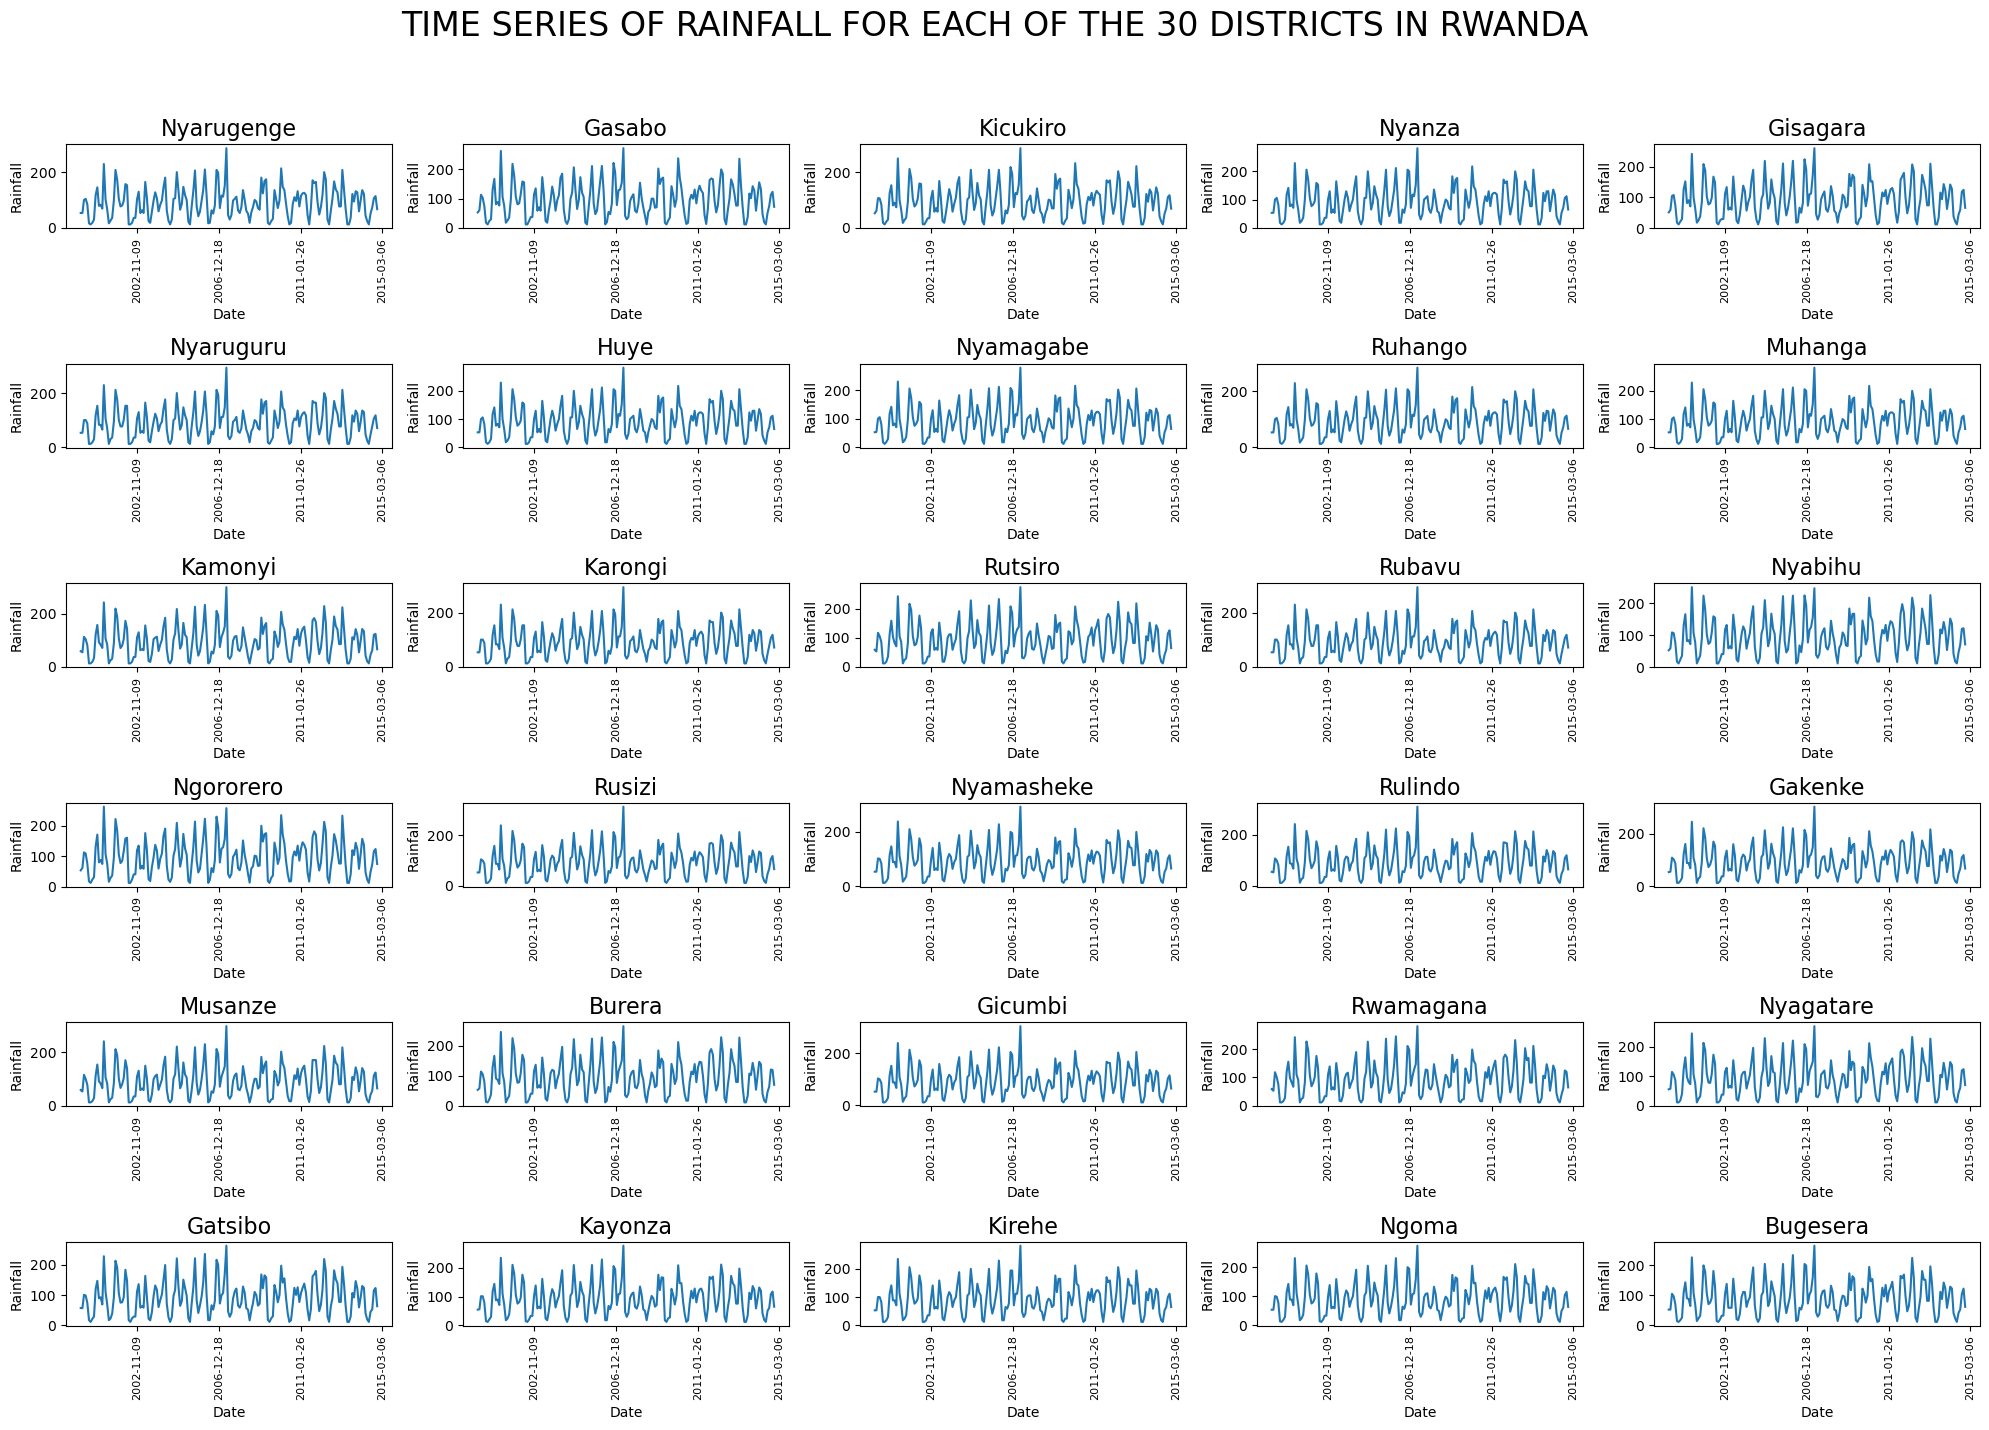

In [21]:
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(20, 15))
axes = axes.flatten()

fig.suptitle('TIME SERIES OF RAINFALL FOR EACH OF THE 30 DISTRICTS IN RWANDA', fontsize=24)
for i, (column, col_val) in enumerate(rwanda_rainfall_df_transposed.iteritems()):
    ax = axes[i]
    ax.plot(col_val)
     
    ax.tick_params(axis='x', rotation=90, labelsize=8)  
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4)) 
    ax.set_title(column, fontsize=16)
    ax.set_xlabel('Date')
    ax.set_ylabel('Rainfall')
    

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

In [22]:
rwanda_veg_df_transposed = rwanda_veg_df.transpose()
rwanda_veg_df_transposed.columns = rwanda_veg_df_transposed.iloc[0]
rwanda_veg_df_transposed = rwanda_veg_df_transposed.iloc[1:]

In [23]:
rwanda_veg_df_transposed.index.name = 'Month'
rwanda_veg_df_transposed. reset_index(inplace = True)
rwanda_veg_df_transposed.columns.name = None 

In [24]:
rwanda_veg_df_transposed[['Month', 'Year']] = rwanda_veg_df_transposed['Month'].str.split('.', expand=True)
rwanda_veg_df_transposed['Year'] = rwanda_veg_df_transposed['Year'].fillna(0)

# Add default year to all values
default_year = 2000
rwanda_veg_df_transposed['Year'] = rwanda_veg_df_transposed['Year'].astype(int) + default_year

# Convert to datetime
rwanda_veg_df_transposed['Month'] = pd.to_datetime(rwanda_veg_df_transposed['Month'] + '.' + rwanda_veg_df_transposed['Year'].astype(str), format='%b.%Y')

# Drop the 'Year' column if it's no longer needed
rwanda_veg_df_transposed.drop(columns=['Year'], inplace=True)
rwanda_veg_df_transposed = rwanda_veg_df_transposed.rename(columns = {'Month':'Date'})

In [25]:
rwanda_veg_df_transposed.set_index('Date', inplace = True)

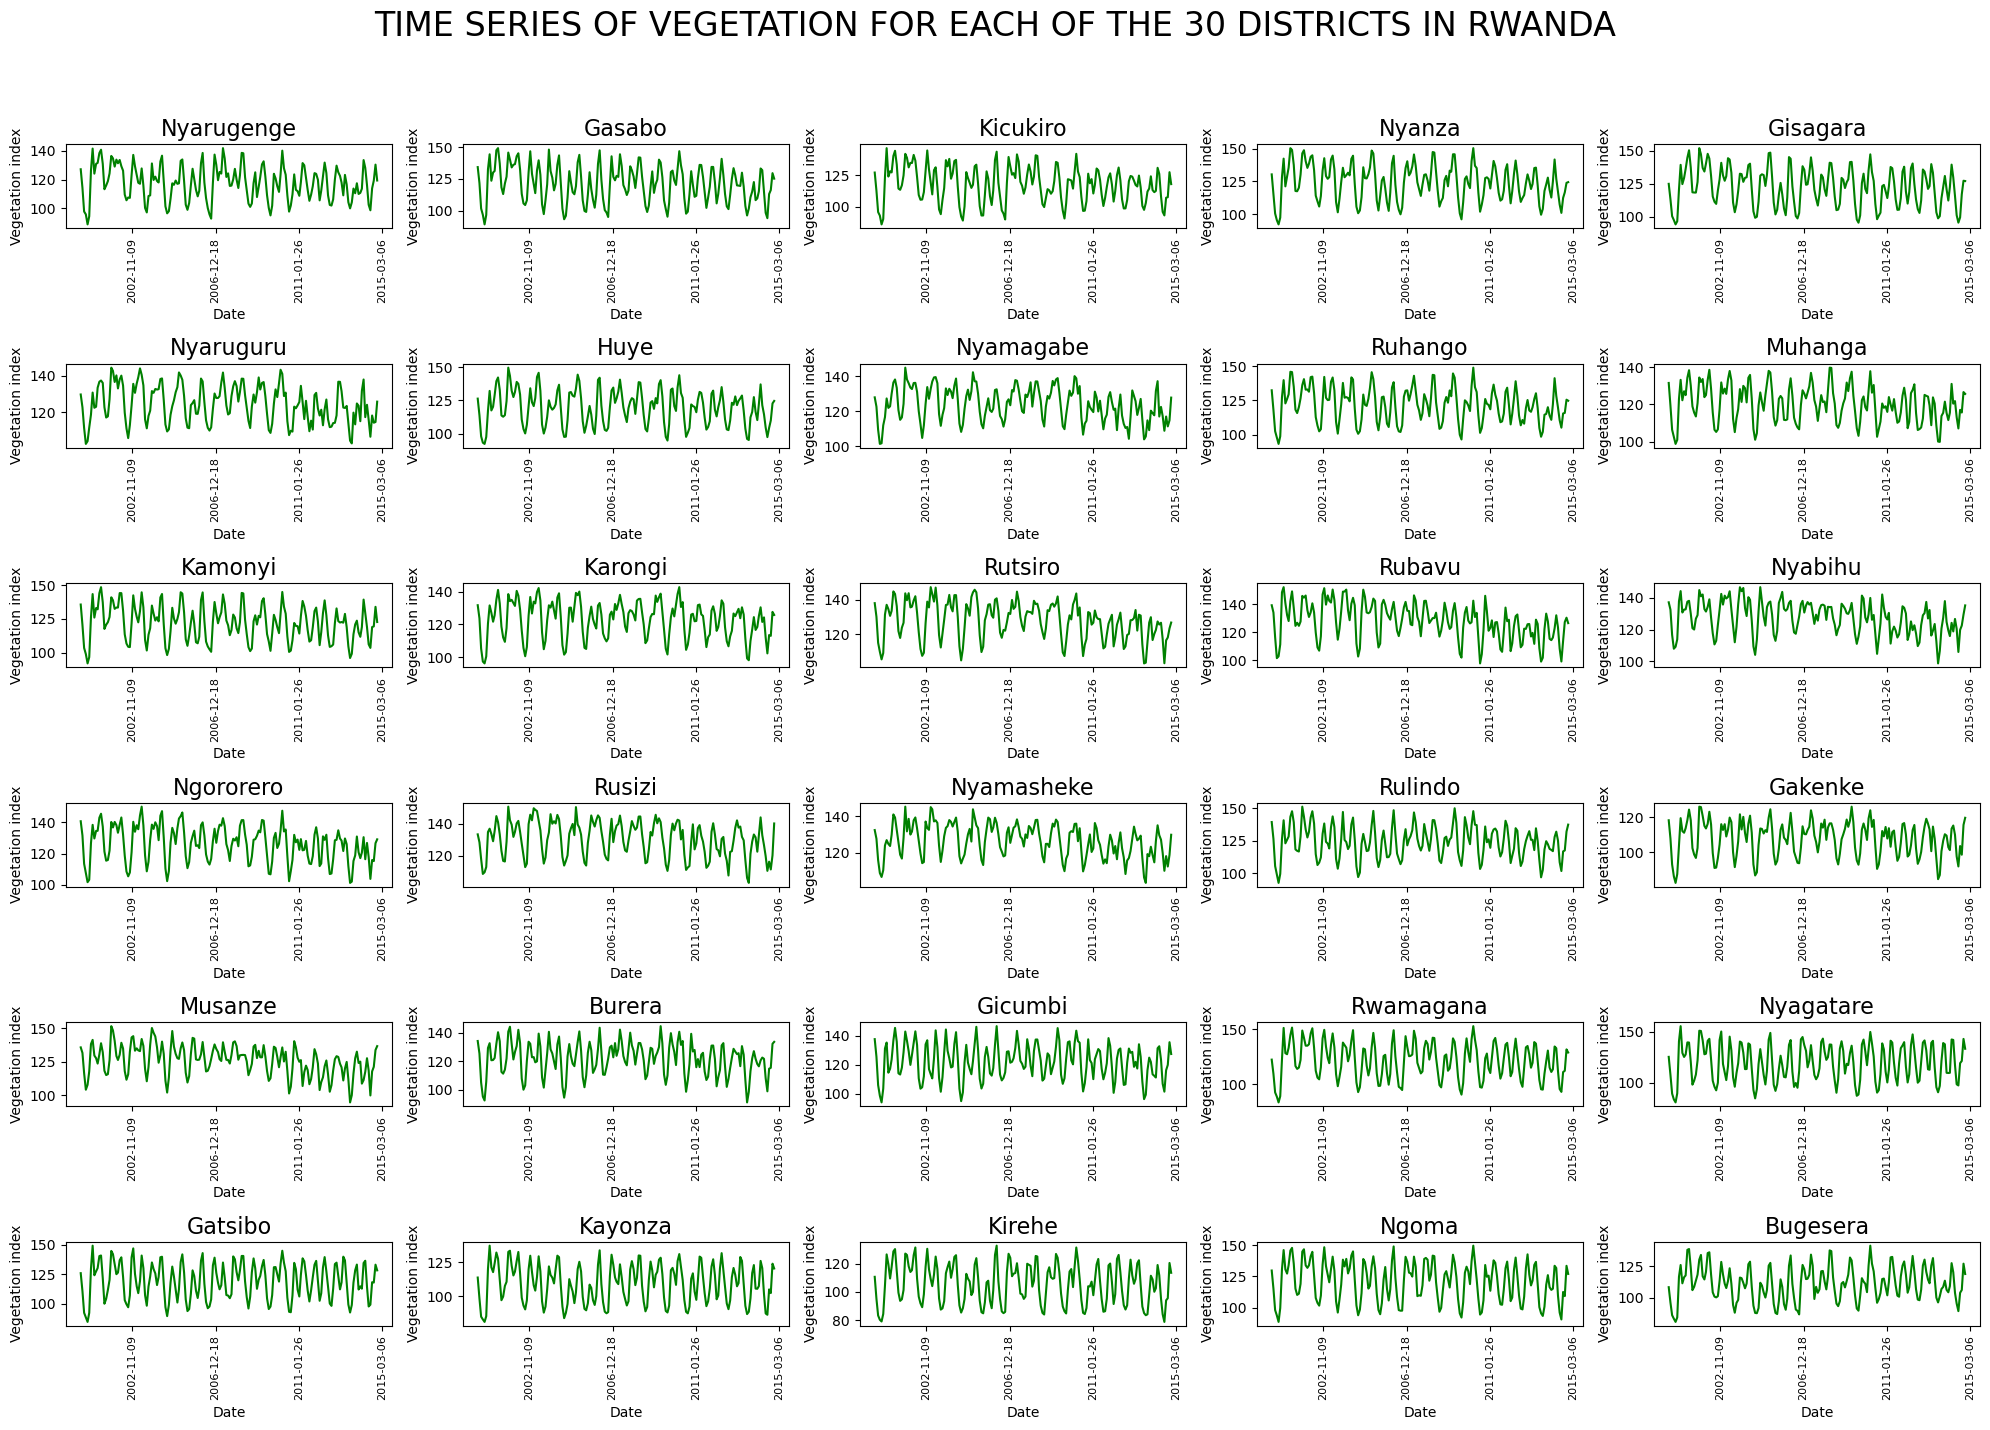

In [26]:
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(20, 15))
axes = axes.flatten()
fig.suptitle('TIME SERIES OF VEGETATION FOR EACH OF THE 30 DISTRICTS IN RWANDA',  fontsize=24)

for i, (column, col_val) in enumerate(rwanda_veg_df_transposed.iteritems()):
    ax = axes[i]
    ax.plot(col_val, color = 'green')
  
    ax.tick_params(axis='x', rotation=90, labelsize=8)  
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4)) 
    ax.set_title(column,fontsize=16)
    ax.set_xlabel('Date')
    ax.set_ylabel('Vegetation index')
    

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

**QUESTION 3 Statistical Analysis of Monthly Rainfall and Vegetation Indices**

Calculate the mean, median, minimum and maximum of the rainfall for each month of the
year (this implies 12 monthly values and not 180 months!). Plot these four variables against
time (month of the year) on a graph. Make a second graph showing the same statistical
quantities for the vegetation index. Label the graphs to indicate each of the four quantities

In [27]:
#rwanda_veg_df_transposed.head(1)

In [28]:
rwanda_veg_df_transposed.reset_index(inplace = True)
rwanda_rainfall_df_transposed.reset_index(inplace = True)

In [29]:
rainfall_dict_ = {}
#retrieve monthly rainfall data
months = range(1, 13)
for month in months:
    rainfall_dict_[month] = rwanda_rainfall_df_transposed.iloc[:,1:][rwanda_rainfall_df_transposed['Date'].dt.month == month]

In [30]:
mean_rainfall_vals = []
median_rainfall_vals = []
min_rainfall_vals = []
max_rainfall_vals = []

for key , values in rainfall_dict_.items():
    mean_rainfall = rainfall_dict_[key].mean().mean() #calculate mean
    mean_rainfall_vals.append(mean_rainfall) 
    
    median_rainfall = rainfall_dict_[key].median().median() #calculate median
    median_rainfall_vals.append(median_rainfall)
    
    min_rainfall = rainfall_dict_[key].min().min() #calculate minimum
    min_rainfall_vals.append(min_rainfall) 
    
    max_rainfall = rainfall_dict_[key].max().max() #calculate aximum
    max_rainfall_vals.append(max_rainfall)

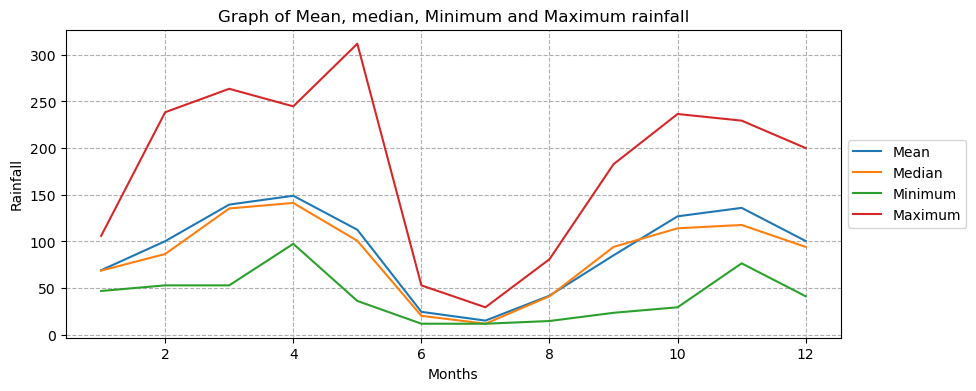

In [31]:
#Graph of Rainfall statistics 
plt.figure(figsize = (10,4))
plt.plot(months, mean_rainfall_vals, label='Mean')
plt.plot(months, median_rainfall_vals, label='Median')
plt.plot(months, min_rainfall_vals, label='Minimum')
plt.plot(months, max_rainfall_vals, label='Maximum')
plt.title('Graph of Mean, median, Minimum and Maximum rainfall')
plt.xlabel('Months')
plt.ylabel('Rainfall')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.grid(linestyle='--')
plt.show()

In [32]:

vegetation_dict_ = {}
#retrieve monthly data
months = range(1, 13)
for month in months:
    vegetation_dict_[month] = rwanda_veg_df_transposed.iloc[:,1:][rwanda_veg_df_transposed['Date'].dt.month == month]

In [33]:
mean_veg_vals = []
median_veg_vals = []
min_veg_vals = []
max_veg_vals = []

for key , values in vegetation_dict_.items():
    mean_veg = vegetation_dict_[key].mean().mean() #alculate mean
    mean_veg_vals.append(mean_veg)
    
    median_veg = vegetation_dict_[key].median().median() #calculate median
    median_veg_vals.append(median_veg)
    
    min_veg = vegetation_dict_[key].min().min() #alculate minimum
    min_veg_vals.append(min_veg)
    
    max_veg = vegetation_dict_[key].max().max() #calculate maximum
    max_veg_vals.append(max_veg)

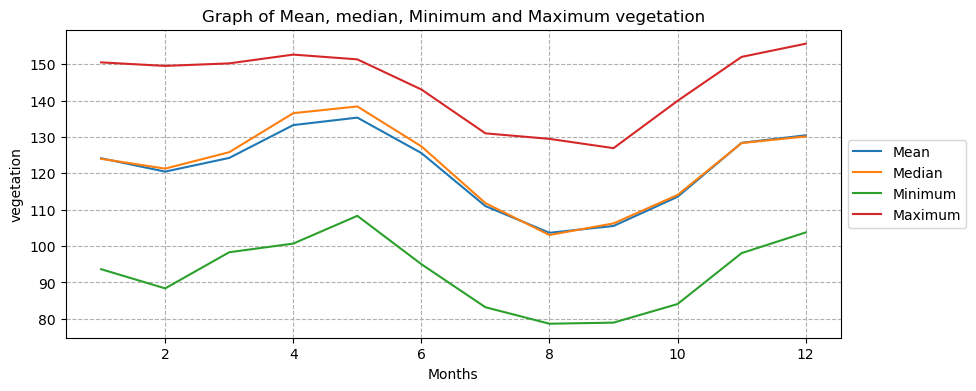

In [34]:
#Graph of veg statistics 
plt.figure(figsize = (10,4))
plt.plot(months, mean_veg_vals, label='Mean')
plt.plot(months, median_veg_vals, label='Median')
plt.plot(months, min_veg_vals, label='Minimum')
plt.plot(months, max_veg_vals, label='Maximum')
plt.title('Graph of Mean, median, Minimum and Maximum vegetation')
plt.xlabel('Months')
plt.ylabel('vegetation')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.grid(linestyle='--')
plt.show()

**QUESTION 4 Spatial Correlation Analysis of Rainfall Across Districts**

Calculate the correlation coefficient, C, for rainfall between each pair of districts. Make a
graph to show the correlation values versus the distance, d, measured in km between the pair
of districts

In [35]:
#Rainfall correlation
rainfall_corrs = rwanda_rainfall_df_transposed.iloc[:,1:].astype(float).corr()
rainfall_corrs

,Nyarugenge,Gasabo,Kicukiro,Nyanza,Gisagara,Nyaruguru,Huye,Nyamagabe,Ruhango,Muhanga,...,Musanze,Burera,Gicumbi,Rwamagana,Nyagatare,Gatsibo,Kayonza,Kirehe,Ngoma,Bugesera
Nyarugenge,1.000000,0.991409,0.997057,0.999603,0.992407,0.998568,0.999603,0.999541,0.999931,0.999603,...,0.989470,0.989763,0.996730,0.982149,0.985754,0.989228,0.996173,0.995288,0.994890,0.988224
Gasabo,0.991409,1.000000,0.996538,0.990433,0.990242,0.991103,0.990433,0.991291,0.991105,0.990433,...,0.985234,0.989873,0.989064,0.977278,0.985275,0.980094,0.987633,0.985637,0.985162,0.978529
Kicukiro,0.997057,0.996538,1.000000,0.996850,0.994418,0.995271,0.996850,0.997432,0.997069,0.996850,...,0.988607,0.989416,0.994146,0.980330,0.985703,0.987000,0.993988,0.992058,0.991816,0.985135
Nyanza,0.999603,0.990433,0.996850,1.000000,0.991890,0.996664,1.000000,0.999791,0.999865,1.000000,...,0.988211,0.988112,0.996061,0.980960,0.984025,0.988803,0.996154,0.995645,0.995001,0.988098
Gisagara,0.992407,0.990242,0.994418,0.991890,1.000000,0.991228,0.991890,0.994073,0.992292,0.991890,...,0.989314,0.989374,0.990620,0.984612,0.986137,0.995676,0.995364,0.989196,0.993057,0.990796
Nyaruguru,0.998568,0.991103,0.995271,0.996664,0.991228,1.000000,0.996664,0.996886,0.997871,0.996664,...,0.989710,0.990732,0.995827,0.982273,0.986868,0.987887,0.994044,0.992442,0.992515,0.986313
Huye,0.999603,0.990433,0.996850,1.000000,0.991890,0.996664,1.000000,0.999791,0.999865,1.000000,...,0.988211,0.988112,0.996061,0.980960,0.984025,0.988803,0.996154,0.995645,0.995001,0.988098
Nyamagabe,0.999541,0.991291,0.997432,0.999791,0.994073,0.996886,0.999791,1.000000,0.999743,0.999791,...,0.989501,0.989411,0.996259,0.982621,0.985451,0.990889,0.997099,0.995617,0.995695,0.989518
Ruhango,0.999931,0.991105,0.997069,0.999865,0.992292,0.997871,0.999865,0.999743,1.000000,0.999865,...,0.989044,0.989172,0.996543,0.981752,0.985129,0.989148,0.996259,0.995527,0.995029,0.988267
Muhanga,0.999603,0.990433,0.996850,1.000000,0.991890,0.996664,1.000000,0.999791,0.999865,1.000000,...,0.988211,0.988112,0.996061,0.980960,0.984025,0.988803,0.996154,0.995645,0.995001,0.988098


In [36]:
districts_lon_lat = rwanda_lon_lat_df[['District', 'Longitude', 'Latitude']]
rainfall_distances = {}


for i in range(len(rwanda_lon_lat_df)):
    for n in range(len(rwanda_lon_lat_df)):
        lat_1 = rwanda_lon_lat_df['Latitude'].iloc[i]
        lat_2 = rwanda_lon_lat_df['Latitude'].iloc[n]
        lon_1 = rwanda_lon_lat_df['Longitude'].iloc[i]
        lon_2 = rwanda_lon_lat_df['Longitude'].iloc[n]
        distance = haversine((lat_1, lon_1), (lat_2, lon_2),unit=Unit.KILOMETERS )
        rainfall_distances[(rwanda_lon_lat_df['District'].iloc[i],rwanda_lon_lat_df['District'].iloc[n])] = distance
        

In [37]:

rows = list(set(key[0] for key in rainfall_distances.keys()))
columns = list(set(key[1] for key in rainfall_distances.keys()))

# Create an empty DataFrame with row and column index names
distance_df = pd.DataFrame(index=rows, columns=columns)


for (row, column), value in rainfall_distances.items():
    distance_df.loc[row, column] = value

distance_df.head(2)

,Ngororero,Gicumbi,Nyaruguru,Gasabo,Rusizi,Gisagara,Nyarugenge,Gakenke,Burera,Kirehe,...,Nyanza,Nyamagabe,Rubavu,Huye,Musanze,Karongi,Bugesera,Ruhango,Nyagatare,Rwamagana
Ngororero,0.0,66.881289,91.033977,63.670169,93.344164,87.76881,52.608375,31.101943,53.955342,132.833011,...,56.686125,60.347057,35.425143,73.568292,42.378801,34.600147,76.049974,41.690238,108.236126,87.941808
Gicumbi,66.881289,0.0,136.538774,30.173157,154.992513,114.807258,42.259363,37.624318,36.309083,95.065117,...,87.040926,113.28579,85.791793,110.04382,58.021566,96.408775,68.857821,74.102753,43.210691,47.595876


In [38]:
#Align the distance dataframe with the rainfall correlation dataframe
distance_df_ = distance_df.reindex(rainfall_corrs.index)
distance_df_ = distance_df_ [rainfall_corrs.columns]
distance_df_.head(2)

,Nyarugenge,Gasabo,Kicukiro,Nyanza,Gisagara,Nyaruguru,Huye,Nyamagabe,Ruhango,Muhanga,...,Musanze,Burera,Gicumbi,Rwamagana,Nyagatare,Gatsibo,Kayonza,Kirehe,Ngoma,Bugesera
Nyarugenge,0.0,16.843215,12.900968,46.326069,72.599086,96.66137,69.083412,77.666327,36.314072,34.27046,...,72.204558,62.637636,42.259363,36.259972,82.504522,62.149735,70.067002,80.379167,52.118738,30.670358
Gasabo,16.843215,0.0,13.057202,62.799443,87.347914,113.171182,85.302515,94.463287,53.136188,47.149327,...,73.843142,58.876578,30.173157,25.400035,66.947446,45.306746,55.780359,73.755908,47.708149,38.741374


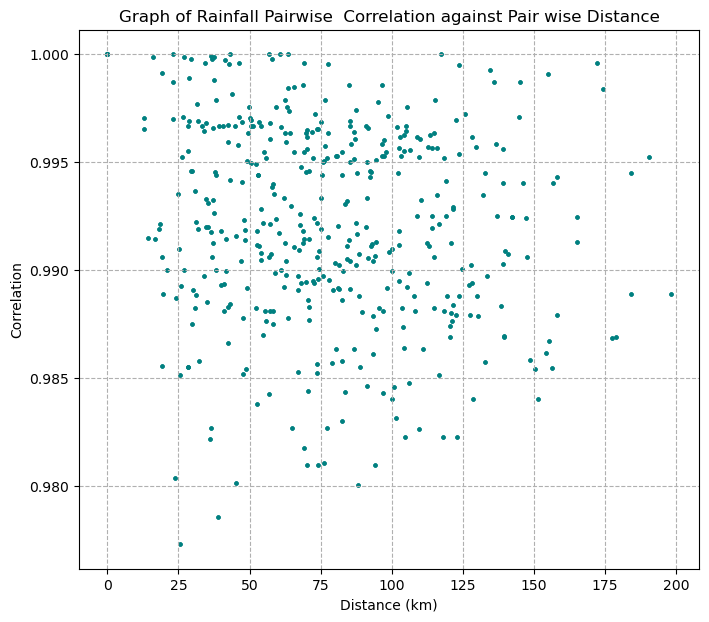

In [39]:
#Graph of Rainfall Correlation  against Distance
plt.figure(figsize = (8, 7))
plt.scatter(distance_df_.values.flatten(), rainfall_corrs.values.flatten() , s = 5, color = 'teal')
plt.title('Graph of Rainfall Pairwise  Correlation against Pair wise Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Correlation')
plt.grid(linestyle='--')
plt.show()

Fit a model of the form, C(d) = C0exp(-ad) by estimating C0 and the decay constant
a. Plot this curve on the graph to show how quickly the correlation declines with distance. Also
provide your estimate of C0 and the decay constant a

In [40]:
rwanda_rainfall_df_transposed

def model_func(d, c_0_, a):
    return c_0_ * np.exp( - a * d)
    

In [41]:
optimal_params, _ = curve_fit(model_func, distance_df.values.flatten(), rainfall_corrs.values.flatten(), p0 = [0.02, 0.00005])

In [42]:
print(f'Estimated C0 and decay constant values are {optimal_params[0],optimal_params[1] } respectively')

Estimated C0 and decay constant values are (0.9926354531656661, 4.23586128857142e-06) respectively


In [43]:
#retrive parameters
a, d = optimal_params
model_x_vals = np.linspace(min( distance_df.values.flatten()), max( distance_df.values.flatten()), 770)
model_y_vals = model_func(model_x_vals, a, d)

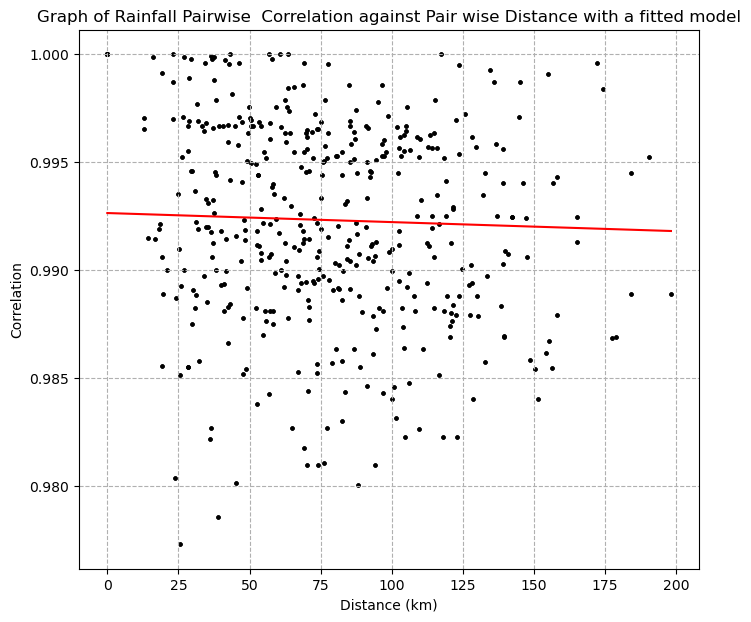

In [44]:
#Graph of Rainfall Correlation  against Distance
plt.figure(figsize = (8, 7))
plt.scatter(distance_df_.values.flatten(), rainfall_corrs.values.flatten() , s = 5, color = 'black')
plt.plot(model_x_vals, model_y_vals, color = 'red', label = 'Model')
plt.title('Graph of Rainfall Pairwise  Correlation against Pair wise Distance with a fitted model')
plt.xlabel('Distance (km)')
plt.ylabel('Correlation')
plt.grid(linestyle='--')
plt.show()

**QUESTION 5 Comparative Analysis of Rainfall and Vegetation Index Time Series**

Synchronize the dates corresponding to both time series and make a scatter plot of
vegetation index against rainfall for the same months.Again use different colors and
symbols to distinguish between the different districts and create a figure legend

In [45]:
synchronized_data = rwanda_rainfall_df_transposed.merge(rwanda_veg_df_transposed, on = 'Date', how = 'inner')

In [46]:
synchronized_data.set_index('Date', inplace = True)

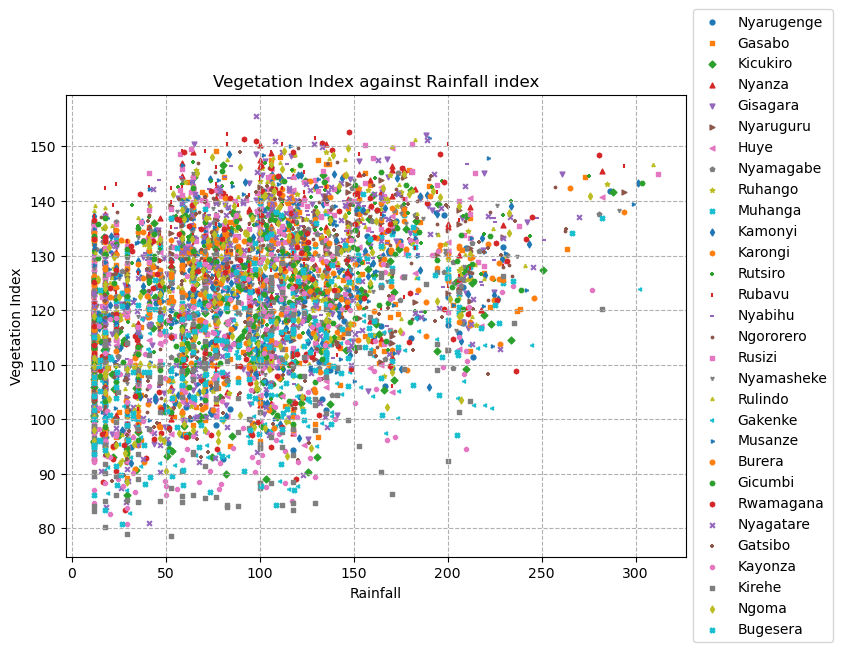

In [47]:
#Retrieve district names
dist_names = synchronized_data.columns.str.split('_').str[0].unique()
markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'X', 'd', 'h', '+', '|', '_', '.', ',', '1', '2', '3', '4', '8', 'H', 'h', 'x', '+', 'P', 's', 'd', 'X']


#Retrieve each districts data
plt.figure(figsize = (8,6))
for name, marker in zip(dist_names, markers):
      plt.scatter(synchronized_data[name + '_x'],synchronized_data[name + '_y'], s = 12, label = name, marker = marker)

plt.title('Vegetation Index against Rainfall index')
plt.xlabel('Rainfall')
plt.ylabel('Vegetation Index')
plt.legend(loc = 'center left', bbox_to_anchor = [1, 0.5])
plt.grid(linestyle = '--')
plt.show()
    

**QUESTION 6- Optimizing Time Delays for Predicting Vegetation Indices from Rainfall Data**

Can you create a new feature by transforming the rainfall time series that provides better
predictions of the vegetation index? One idea is to use a delayed time series to test rainfall in
month t-k against vegetation index in month t.

In [48]:
#Retrieve values for rainfall in synchronized values
rainfall_index_df = synchronized_data.filter(like = '_x')
vegetation_index_df = synchronized_data.filter(like = '_y')

In [49]:
#Reset indices
rainfall_index_df.reset_index(inplace=True)
vegetation_index_df.reset_index(inplace=True)

In [50]:
all_dists_corr_vals = {}
shift_vals = range(0, 13)

#use delayed rainfall to predict vegetation index
for dist_name in rainfall_index_df.columns[1:]:
    dist_k_corr =    {}
    for k in shift_vals:
        rainfall_index_df_delayed = rainfall_index_df[dist_name].shift(k).dropna() #ddelay for by k value
        vegetation_dist = vegetation_index_df[dist_name.replace('_x', '_y')]
        #print(vegetation_dist)
        corr = rainfall_index_df_delayed.astype(float).corr(vegetation_dist.astype(float))
        dist_k_corr[k] = corr
        
    all_dists_corr_vals[dist_name] = dist_k_corr
   

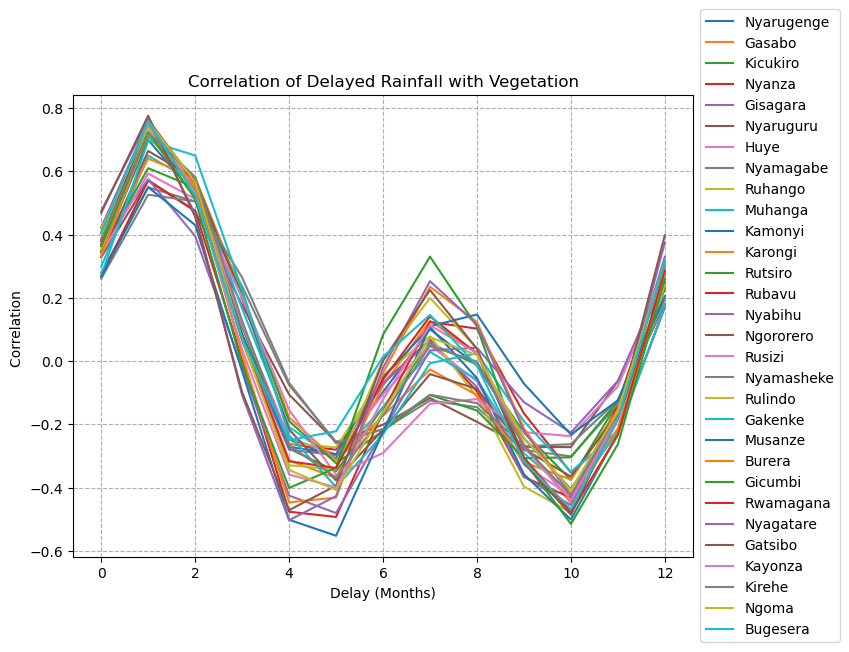

In [51]:
#Plot the shifts and correlations for each district
plt.figure(figsize = (8,6))
for key, corr_dict in all_dists_corr_vals.items():
    shift_vals = []
    corr_vals = []
    
    for k , corr in corr_dict.items():
        shift_vals.append(k)
        corr_vals.append(corr)
    plt.plot(shift_vals, corr_vals, label = key.split('_')[0])
plt.title('Correlation of Delayed Rainfall with Vegetation')
plt.xlabel('Delay (Months)')
plt.ylabel('Correlation ')
plt.grid(linestyle='--')
plt.legend(loc = 'center left', bbox_to_anchor = [1,0.5])
plt.show() 

In [52]:
districts = []
optimal_k = []
corr_optimal = []
#Tabulate optimal value of k   

for key, corr_dict in all_dists_corr_vals.items():
  
    for k , corr in corr_dict.items():
        if corr == max(corr_dict.values()):
            optimal_k.append(k)
            corr_optimal.append(corr)
            districts.append(key)

table_data = []
for district, k, corre in zip(districts, optimal_k, corr_optimal):
    dist,  _= district.split('_')
    tab_entry = [dist, k, corre]
    table_data.append(tab_entry)


header = ['District', 'Optimal k', 'Maximum Correlation']
row_format = "{:<15} {:<10} {:<20}"

# Function to orint table
def print_table(header, data):
    print(row_format.format(*header)) 
    print('-' * 45)  # Print a separator
    for row in data:
        print(row_format.format(*row))  
        print('-' * 45) 

print_table(header, table_data)


District        Optimal k  Maximum Correlation 
---------------------------------------------
Nyarugenge      1          0.6994017920728123  
---------------------------------------------
Gasabo          1          0.7447431414818062  
---------------------------------------------
Kicukiro        1          0.7120285951667081  
---------------------------------------------
Nyanza          1          0.7411487389764839  
---------------------------------------------
Gisagara        1          0.7579122293026155  
---------------------------------------------
Nyaruguru       1          0.570605577174536   
---------------------------------------------
Huye            1          0.7397659130350541  
---------------------------------------------
Nyamagabe       1          0.5492118142593836  
---------------------------------------------
Ruhango         1          0.7188122727210124  
---------------------------------------------
Muhanga         1          0.6492620336651267  
------------

**QUESTION 7 - Moving Average Transformation of Rainfall for Enhanced Vegetation Index Prediction**

Another idea for a new feature is to take moving averages of rainfall over the last n months.
What is the optimal value of n for each district and is there a consensus? Use correlation to
inform your decision. Provide a graph instead of a table showing correlation for each n months.
Consider the moving average window, n, ranging from 1 to 12


In [53]:
windows = range(1,13)
all_dists_corr_vals = {}

#Loop through districts to calculate SMA
for dist_name in rainfall_index_df.columns[1:]:
    dist_k_corr =    {}
    
    for window in windows:
        rainfall_SMA = rainfall_index_df[dist_name].rolling(window = window).mean().dropna() #calculate SMA
        vegetation_dist = vegetation_index_df[dist_name.replace('_x', '_y')]

        corr = rainfall_SMA.astype(float).corr(vegetation_dist.astype(float)) #calculate correlation
        #print(corr)
        dist_k_corr[window] = corr
        
    all_dists_corr_vals[dist_name] = dist_k_corr

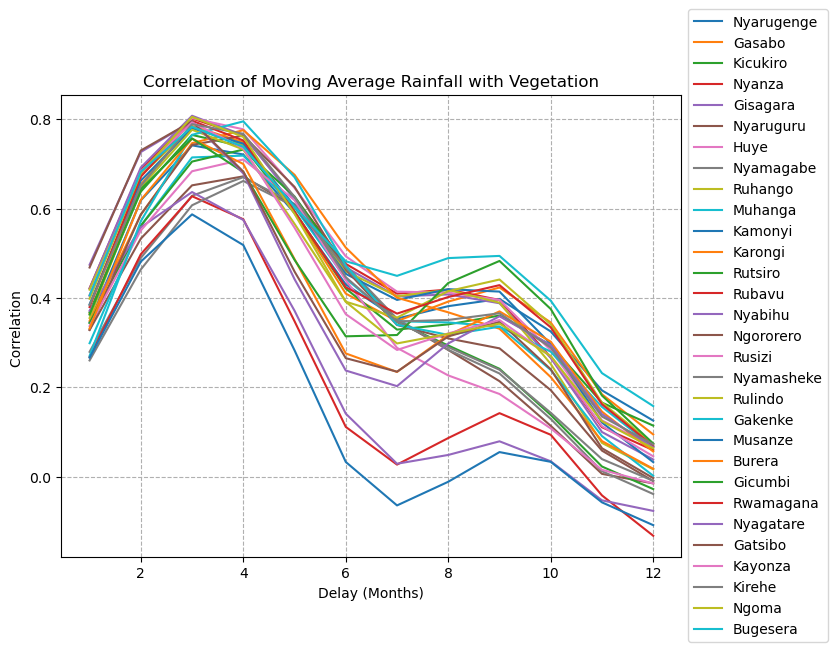

In [54]:
#Plot the shifts and correlations for each district
plt.figure(figsize = (8,6))
for key, corr_dict in all_dists_corr_vals.items():
    shift_vals = []
    corr_vals = []
    
    for k , corr in corr_dict.items():
        shift_vals.append(k)
        corr_vals.append(corr)
    plt.plot(shift_vals, corr_vals, label = key.split('_')[0])
plt.title('Correlation of Moving Average Rainfall with Vegetation')
plt.xlabel('Delay (Months)')
plt.ylabel('Correlation ')
plt.grid(linestyle='--')
plt.legend(loc = 'center left', bbox_to_anchor = [1,0.5])
plt.show() 

In [55]:
districts = []
optimal_k = []
corr_optimal = []
    
#districts = rainfall_index_df.columns[1:]
for key, corr_dict in all_dists_corr_vals.items():
  
    for k , corr in corr_dict.items():
        if corr == max(corr_dict.values()):
            optimal_k.append(k)
            corr_optimal.append(corr)
            districts.append(key)

table_data = []
for dist, k, corre in zip(districts, optimal_k, corr_optimal):
    district, _ = dist.split('_')
    tab_entry = [district, k, corre]
    table_data.append(tab_entry)
    
#define table headings
header = ['District', 'Optimal window', 'Correlation']
row_format = "{:<15} {:<10} {:<20}"

# Create a function to print the table
def print_table(header, data):
    print(row_format.format(*header)) 
    print('-' * 45)  # Print a separator
    for row in data:
        print(row_format.format(*row))  
        print('-' * 45) 

print_table(header, table_data)

District        Optimal window Correlation         
---------------------------------------------
Nyarugenge      3          0.742121728247808   
---------------------------------------------
Gasabo          3          0.7855086940667928  
---------------------------------------------
Kicukiro        3          0.7654141799873369  
---------------------------------------------
Nyanza          3          0.8022216850323692  
---------------------------------------------
Gisagara        3          0.8083749961640101  
---------------------------------------------
Nyaruguru       4          0.6725956674002159  
---------------------------------------------
Huye            3          0.8030325621599778  
---------------------------------------------
Nyamagabe       4          0.6708270124700262  
---------------------------------------------
Ruhango         3          0.7838845292030978  
---------------------------------------------
Muhanga         4          0.71905573946089    
--------

  **QUESTION 8 Modeling Vegetation Response to Rainfall Using Polynomial Regression**

Is there any evidence for using a quadratic model to describe how the vegetation index
varies with rainfall (or any of the above features: delayed rainfall and simple moving average
rainfall)? What about higher order nonlinear relationships? Kindly limit consideration to cubic for
the highest order. (Use the table format for the answer suggested below).

**Rainfall**

In [56]:
#Function to calculate adjusted r squared from r squared
def adjusted_r2(r2,n, d):
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - d - 1)
    return adjusted_r2

In [57]:
#Define dependent and independent values
X_1 = synchronized_data.filter(like = '_x').astype(float).values.flatten()
y_1= synchronized_data.filter(like = '_y').astype(float).values.flatten()


In [58]:
#Linear model
linear_model_coeffs = np.polyfit(X_1, y_1, 1)

#make predictions using linear model
linear_model_preds = np.polyval(linear_model_coeffs,X_1 )
linear_r2_score = r2_score(y_1, linear_model_preds)
linear_adjusted_r2_score = adjusted_r2(linear_r2_score,len(X_1), 1 )
linear_adjusted_rmse = np.sqrt(mean_squared_error(y_1, linear_model_preds))
linear_model_metrics = [linear_r2_score,linear_adjusted_r2_score, linear_adjusted_rmse ]


In [59]:
#linear_model_metrics

In [60]:
#quad model
quad_model_coeffs = np.polyfit(X_1, y_1, 2)

#make predictions using quad model
quad_model_preds = np.polyval(quad_model_coeffs,X_1 )
quad_r2_score = r2_score(y_1, quad_model_preds)
quad_adjusted_r2_score = adjusted_r2(quad_r2_score,len(X_1), 1 )
quad_adjusted_rmse = np.sqrt(mean_squared_error(y_1, quad_model_preds))
quad_model_metrics = [quad_r2_score,quad_adjusted_r2_score, quad_adjusted_rmse ]


In [61]:
#cubic model
cubic_model_coeffs = np.polyfit(X_1, y_1, 3)

#make predictions using cubic model
cubic_model_preds = np.polyval(cubic_model_coeffs,X_1 )
cubic_r2_score = r2_score(y_1, cubic_model_preds)
cubic_adjusted_r2_score = adjusted_r2(cubic_r2_score,len(X_1), 1 )
cubic_adjusted_rmse = np.sqrt(mean_squared_error(y_1, cubic_model_preds))
cubic_model_metrics = [cubic_r2_score,cubic_adjusted_r2_score, cubic_adjusted_rmse ]


In [62]:
qn8_data = [linear_model_metrics, quad_model_metrics, cubic_model_metrics]

# Initialize the rainfall_metrics_ dictionary with labels as keys
labels = ['Linear', 'Quadratic', 'Cubic']
rainfall_metrics_ = {label: {} for label in labels}

# Update the rainfall_metrics_ dictionary with the metrics
for metrics, label in zip(qn8_data, labels):
    rainfall_metrics_[label]['R2 score'] = metrics[0]
    rainfall_metrics_[label]['Adjusted R2 score'] = metrics[1]
    rainfall_metrics_[label]['RMSE'] = metrics[2]

# Checking the updated dictionary
rainfall_metrics_

# Prepare the data for tabulation
table_data = [[label] + list(details.values()) for label, details in rainfall_metrics_.items()]

# Print the table using tabulate
print(tabulate(table_data, headers=["Model", "R2 score", "Adjusted R2 score", "RMSE"], tablefmt="fancy_grid"))

╒═══════════╤════════════╤═════════════════════╤═════════╕
│ Model     │   R2 score │   Adjusted R2 score │    RMSE │
╞═══════════╪════════════╪═════════════════════╪═════════╡
│ Linear    │   0.109453 │            0.109284 │ 13.1976 │
├───────────┼────────────┼─────────────────────┼─────────┤
│ Quadratic │   0.116198 │            0.11603  │ 13.1476 │
├───────────┼────────────┼─────────────────────┼─────────┤
│ Cubic     │   0.118972 │            0.118805 │ 13.1269 │
╘═══════════╧════════════╧═════════════════════╧═════════╛


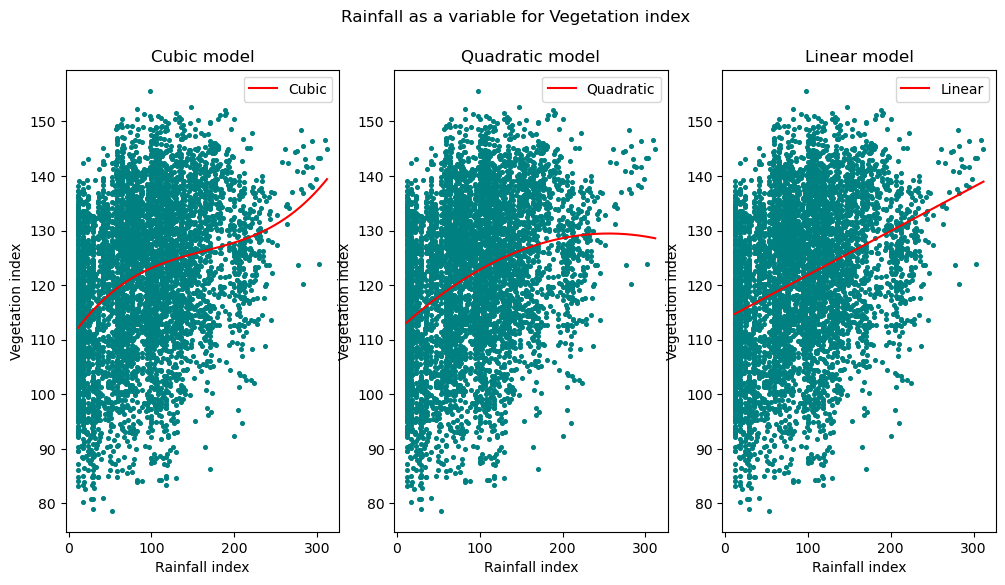

In [63]:
#visualie models
quad_model_preds_vals = np.polyval(quad_model_coeffs, np.linspace(min(X_1), max(X_1), 900) )
cubic_model_preds_vals = np.polyval(cubic_model_coeffs, np.linspace(min(X_1), max(X_1), 900) )
linear_model_preds_vals = np.polyval(linear_model_coeffs, np.linspace(min(X_1), max(X_1), 900) )

#Retrieve district names
dist_names = synchronized_data.columns.str.split('_').str[0].unique()


#Retrieve each districts data
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

plt.suptitle('Rainfall as a variable for Vegetation index')
axs[0].plot( np.linspace(min(X_1), max(X_1), 900), cubic_model_preds_vals, color = 'red', label = 'Cubic')
axs[0].scatter(X_1, y_1, color = 'teal', s = 7)
axs[0].set_xlabel('Rainfall index')
axs[0].set_ylabel('Vegetation index')
axs[0].set_title('Cubic model')

axs[1].plot( np.linspace(min(X_1), max(X_1), 900), quad_model_preds_vals, color = 'red', label = 'Quadratic')
axs[1].scatter(X_1,y_1, color = 'teal', s = 7)
axs[1].set_xlabel('Rainfall index')
axs[1].set_ylabel('Vegetation index')
axs[1].set_title('Quadratic model')

axs[2].plot( np.linspace(min(X_1), max(X_1), 900), linear_model_preds_vals, color = 'red', label = 'Linear')
axs[2].scatter(X_1,y_1, color = 'teal', s = 7)
axs[2].set_xlabel('Rainfall index')
axs[2].set_ylabel('Vegetation index')
axs[2].set_title('Linear model')

for ax in axs:
    ax.legend()
    
plt.show()
    

**Delayed Rainfall**

In [64]:
X_2 =  synchronized_data.filter(like = '_x').shift(1).dropna().astype(float).values.flatten()
y_2 = synchronized_data.filter(like = '_y').iloc[1:].astype(float).values.flatten()


In [65]:
#Linear model
linear_model_coeffs = np.polyfit(X_2, y_2, 1)

#make predictions using linear model
linear_model_preds = np.polyval(linear_model_coeffs,X_2 )

#
linear_r2_score = r2_score(y_2, linear_model_preds)
linear_adjusted_r2_score = adjusted_r2(linear_r2_score,len(X_2), 1 )
linear_adjusted_rmse = np.sqrt(mean_squared_error(y_2, linear_model_preds))
linear_model_metrics = [linear_r2_score,linear_adjusted_r2_score, linear_adjusted_rmse ]


In [66]:
#quad model
quad_model_coeffs = np.polyfit(X_2, y_2, 2)

#make predictions using quad model
quad_model_preds = np.polyval(quad_model_coeffs,X_2 )
quad_r2_score = r2_score(y_2, quad_model_preds)
quad_adjusted_r2_score = adjusted_r2(quad_r2_score,len(X_2), 1 )
quad_adjusted_rmse = np.sqrt(mean_squared_error(y_2, quad_model_preds))
quad_model_metrics = [quad_r2_score,quad_adjusted_r2_score, quad_adjusted_rmse ]


In [67]:
#cubic model
cubic_model_coeffs = np.polyfit(X_2, y_2, 3)
#make predictions using cubic model
cubic_model_preds = np.polyval(cubic_model_coeffs,X_2 )
cubic_r2_score = r2_score(y_2, cubic_model_preds)
cubic_adjusted_r2_score = adjusted_r2(cubic_r2_score,len(X_2), 1 )
cubic_adjusted_rmse = np.sqrt(mean_squared_error(y_2, cubic_model_preds))
cubic_model_metrics = [cubic_r2_score,cubic_adjusted_r2_score, cubic_adjusted_rmse ]


In [68]:
qn8_data = [linear_model_metrics, quad_model_metrics, cubic_model_metrics]

# Initialize the delayed_rainfall_metrics_ dictionary with labels as keys
labels = ['Linear', 'Quadratic', 'Cubic']
delayed_rainfall_metrics_ = {label: {} for label in labels}

# Update the delayed_rainfall_metrics_ dictionary with the metrics
for metrics, label in zip(qn8_data, labels):
    delayed_rainfall_metrics_[label]['R2 score'] = metrics[0]
    delayed_rainfall_metrics_[label]['Adjusted R2 score'] = metrics[1]
    delayed_rainfall_metrics_[label]['RMSE'] = metrics[2]

# Prepare the data for tabulation
table_data = [[label] + list(details.values()) for label, details in delayed_rainfall_metrics_.items()]

# Print the table using tabulate
print(tabulate(table_data, headers=["Model", "R2 score", "Adjusted R2 score", "RMSE"], tablefmt="fancy_grid"))


╒═══════════╤════════════╤═════════════════════╤═════════╕
│ Model     │   R2 score │   Adjusted R2 score │    RMSE │
╞═══════════╪════════════╪═════════════════════╪═════════╡
│ Linear    │   0.388732 │            0.388615 │ 10.9441 │
├───────────┼────────────┼─────────────────────┼─────────┤
│ Quadratic │   0.446825 │            0.446719 │ 10.411  │
├───────────┼────────────┼─────────────────────┼─────────┤
│ Cubic     │   0.449767 │            0.449662 │ 10.3833 │
╘═══════════╧════════════╧═════════════════════╧═════════╛


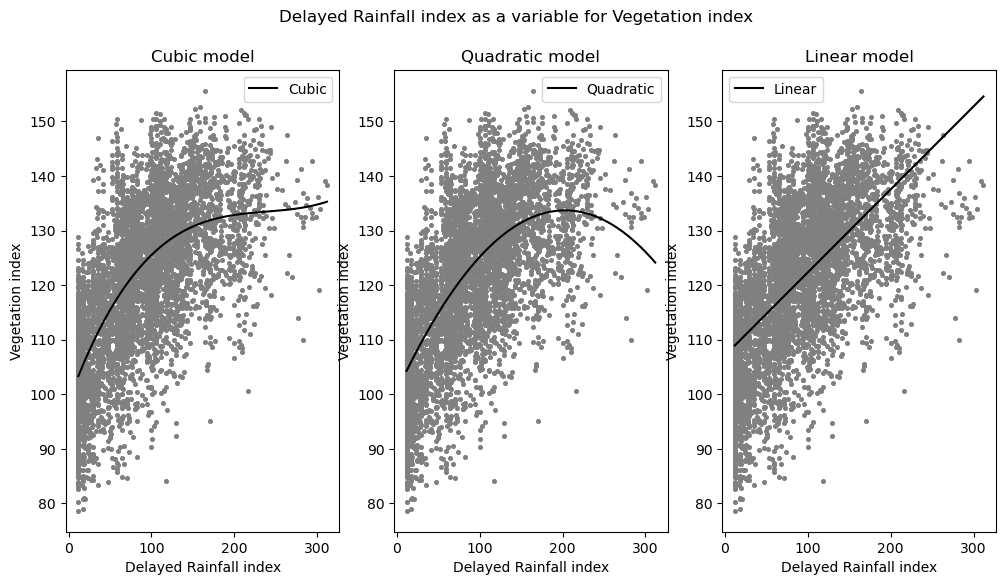

In [69]:
#visualize models
quad_model_preds_vals = np.polyval(quad_model_coeffs, np.linspace(min(X_2), max(X_2), 900) )
cubic_model_preds_vals = np.polyval(cubic_model_coeffs, np.linspace(min(X_2), max(X_2), 900) )
linear_model_preds_vals = np.polyval(linear_model_coeffs, np.linspace(min(X_2), max(X_2), 900) )

#Retrieve district names
dist_names = synchronized_data.columns.str.split('_').str[0].unique()


#Retrieve each districts data
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

plt.suptitle('Delayed Rainfall index as a variable for Vegetation index')
axs[0].plot( np.linspace(min(X_2), max(X_2), 900), cubic_model_preds_vals, color = 'black', label = 'Cubic')
axs[0].scatter(X_2, y_2, color = 'gray', s = 7)
axs[0].set_xlabel('Delayed Rainfall index')
axs[0].set_ylabel('Vegetation index')
axs[0].set_title('Cubic model')

axs[1].plot( np.linspace(min(X_2), max(X_2), 900), quad_model_preds_vals, color = 'black', label = 'Quadratic')
axs[1].scatter(X_2,y_2, color = 'gray', s = 7)
axs[1].set_xlabel('Delayed Rainfall index')
axs[1].set_ylabel('Vegetation index')
axs[1].set_title('Quadratic model')

axs[2].plot( np.linspace(min(X_2), max(X_2), 900), linear_model_preds_vals, color = 'black', label = 'Linear')
axs[2].scatter(X_2,y_2, color = 'gray', s = 7)
axs[2].set_xlabel('Delayed Rainfall index')
axs[2].set_ylabel('Vegetation index')
axs[2].set_title('Linear model')

for ax in axs:
    ax.legend()
    
plt.show()
    

**SMA Rainfall**

In [70]:

#Define dependent and independent values
X_3 = rainfall_index_df.rolling(window = 3).mean().dropna().values.flatten()
y_3 =  synchronized_data.filter(like = '_y').iloc[2:].astype(float).values.flatten()


In [71]:
#rainfall_index_df.iloc[2:]

In [72]:
#Linear model
linear_model_coeffs = np.polyfit(X_3, y_3, 1)

#make predictions using linear model
linear_model_preds = np.polyval(linear_model_coeffs,X_3 )
linear_r2_score = r2_score(y_3, linear_model_preds)
linear_adjusted_r2_score = adjusted_r2(linear_r2_score,len(X_3), 1 )
linear_adjusted_rmse = np.sqrt(mean_squared_error(y_3, linear_model_preds))
linear_model_metrics = [linear_r2_score,linear_adjusted_r2_score, linear_adjusted_rmse ]


In [73]:
#quad model
quad_model_coeffs = np.polyfit(X_3, y_3, 2)

#make predictions using quad model
quad_model_preds = np.polyval(quad_model_coeffs,X_3 )
quad_r2_score = r2_score(y_3, quad_model_preds)
quad_adjusted_r2_score = adjusted_r2(quad_r2_score,len(X_3), 1 )
quad_adjusted_rmse = np.sqrt(mean_squared_error(y_3, quad_model_preds))
quad_model_metrics = [quad_r2_score,quad_adjusted_r2_score, quad_adjusted_rmse ]


In [74]:
#cubic model
cubic_model_coeffs = np.polyfit(X_3, y_3, 3)

#make predictions using cubic model
cubic_model_preds = np.polyval(cubic_model_coeffs,X_3 )
cubic_r2_score = r2_score(y_3, cubic_model_preds)
cubic_adjusted_r2_score = adjusted_r2(cubic_r2_score,len(X_3), 1 )
cubic_adjusted_rmse = np.sqrt(mean_squared_error(y_3, cubic_model_preds))
cubic_model_metrics = [cubic_r2_score,cubic_adjusted_r2_score, cubic_adjusted_rmse ]


In [75]:
qn8_data = [linear_model_metrics, quad_model_metrics, cubic_model_metrics]

# Initialize the SMA_rainfall_metrics_ dictionary with labels as keys
labels = ['Linear', 'Quadratic', 'Cubic']
SMA_rainfall_metrics_ = {label: {} for label in labels}

# Update the SMA_rainfall_metrics_ dictionary with the metrics
for metrics, label in zip(qn8_data, labels):
    SMA_rainfall_metrics_[label]['R2 score'] = metrics[0]
    SMA_rainfall_metrics_[label]['Adjusted R2 score'] = metrics[1]
    SMA_rainfall_metrics_[label]['RMSE'] = metrics[2]

# Prepare the data for tabulation
table_data = [[label] + list(details.values()) for label, details in SMA_rainfall_metrics_.items()]

# Print the table using tabulate
print(tabulate(table_data, headers=["Model", "R2 score", "Adjusted R2 score", "RMSE"], tablefmt="fancy_grid"))


╒═══════════╤════════════╤═════════════════════╤═════════╕
│ Model     │   R2 score │   Adjusted R2 score │    RMSE │
╞═══════════╪════════════╪═════════════════════╪═════════╡
│ Linear    │   0.453645 │            0.45354  │ 10.3586 │
├───────────┼────────────┼─────────────────────┼─────────┤
│ Quadratic │   0.471145 │            0.471043 │ 10.1913 │
├───────────┼────────────┼─────────────────────┼─────────┤
│ Cubic     │   0.471967 │            0.471866 │ 10.1834 │
╘═══════════╧════════════╧═════════════════════╧═════════╛


In [76]:
quad_model_preds_vals = np.polyval(quad_model_coeffs, np.linspace(min(X_3), max(X_3), 900) )
cubic_model_preds_vals = np.polyval(cubic_model_coeffs, np.linspace(min(X_3), max(X_3), 900) )
linear_model_preds_vals = np.polyval(linear_model_coeffs, np.linspace(min(X_3), max(X_3), 900) )

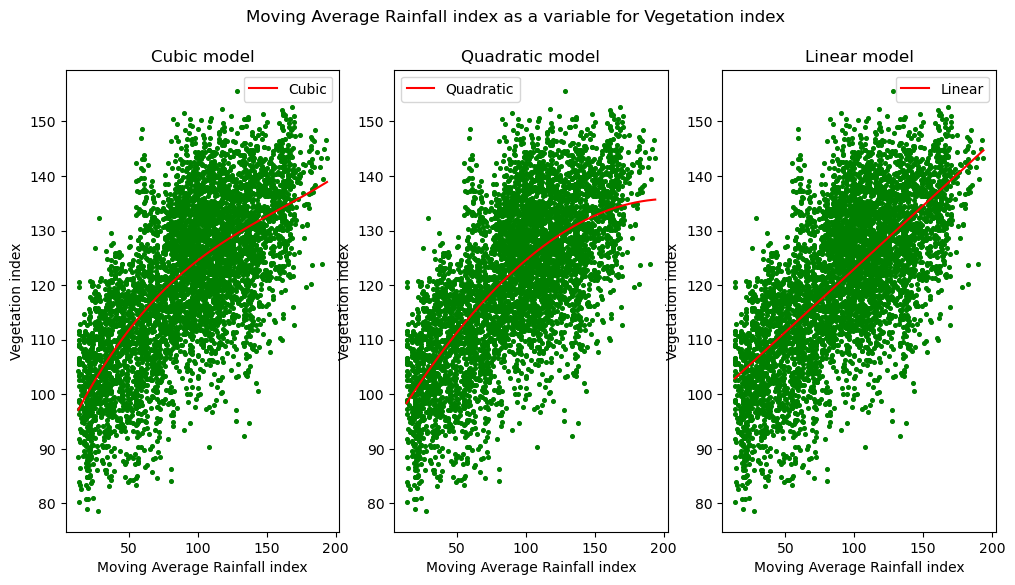

In [77]:
#visualize models
quad_model_preds_vals = np.polyval(quad_model_coeffs, np.linspace(min(X_3), max(X_3), 900) )
cubic_model_preds_vals = np.polyval(cubic_model_coeffs, np.linspace(min(X_3), max(X_3), 900) )
linear_model_preds_vals = np.polyval(linear_model_coeffs, np.linspace(min(X_3), max(X_3), 900) )

#Retrieve district names
dist_names = synchronized_data.columns.str.split('_').str[0].unique()


#Retrieve each districts data
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

plt.suptitle('Moving Average Rainfall index as a variable for Vegetation index')
axs[0].plot( np.linspace(min(X_3), max(X_3), 900), cubic_model_preds_vals, color = 'red', label = 'Cubic')
axs[0].scatter(X_3, y_3, color = 'green', s = 7)
axs[0].set_xlabel('Moving Average Rainfall index')
axs[0].set_ylabel('Vegetation index')
axs[0].set_title('Cubic model')

axs[1].plot( np.linspace(min(X_3), max(X_3), 900), quad_model_preds_vals, color = 'red', label = 'Quadratic')
axs[1].scatter(X_3,y_3, color = 'green', s = 7)
axs[1].set_xlabel('Moving Average Rainfall index')
axs[1].set_ylabel('Vegetation index')
axs[1].set_title('Quadratic model')

axs[2].plot( np.linspace(min(X_3), max(X_3), 900), linear_model_preds_vals, color = 'red', label = 'Linear')
axs[2].scatter(X_3,y_3, color = 'green', s = 7)
axs[2].set_xlabel('Moving Average Rainfall index')
axs[2].set_ylabel('Vegetation index')
axs[2].set_title('Linear model')

for ax in axs:
    ax.legend()
    
plt.show()
    

**QUESTION 9 - Cross-Validation of Rainfall Transformations for Vegetation Index Prediction**

For each district, use cross-validation to select the best transformation, combining moving
averages and delays of the monthly measurements. Provide tables as suggested. Please
remember that it makes sense to first consider the SMA and then a delay afterwards when
combining the moving averages and delay approaches.

In [78]:

class PolyModel(BaseEstimator, RegressorMixin):
    def __init__(self, degree=1):
        self.degree = degree
        self.model_params = None

    def fit(self, X, y):
        X = X.flatten()
        self.model_params = np.polyfit(X, y, self.degree)
        return self

    def predict(self, X):
        X = X.flatten()
        return np.polyval(self.model_params, X)

**Rainfall**

In [79]:
#Retrieve district names
dist_names = synchronized_data.columns.str.split('_').str[0].unique()

    
r2_list = []
adjusted_r2_list = []

#Simple moving average
X_data = rainfall_index_df.iloc[:,1:].astype(float).values.flatten()
y = vegetation_index_df.iloc[:,1:].astype(float).values.flatten()
X_train, X_test, y_train, y_test = train_test_split(X_data, y, random_state=42, test_size=0.2)

linear_model = PolyModel(degree = 1)
quadratic_model = PolyModel(degree = 2)
cubic_model = PolyModel(degree = 3)
X_data = X_test.reshape(-1,1)

#linear model
linear_model.fit(X_test, y_test)
linear_preds = linear_model.predict(X_test.reshape(-1,1))
r2_linear = r2_score(y_test,linear_preds  )
r2_list.append(r2_linear)
adj_r2_linear =  adjusted_r2(r2_linear, X_test.shape[0], 1)
adjusted_r2_list.append(adj_r2_linear)

#quadratic model
quadratic_model.fit(X_test, y_test)
quad_preds = quadratic_model.predict(X_test.reshape(-1,1))
r2_quad = r2_score(y_test,quad_preds )
r2_list.append(r2_quad)
adj_r2_quad =  adjusted_r2(r2_quad,  X_test.shape[0], 1)
adjusted_r2_list.append(adj_r2_quad) 

#cubic model
cubic_model.fit(X_test, y_test)
cubic_preds = cubic_model.predict(X_test.reshape(-1,1))
r2_cubic = r2_score(y_test, cubic_preds)
r2_list.append(r2_cubic)
adj_r2_cubic =  adjusted_r2(r2_cubic, X_data.shape[0], 1)
adjusted_r2_list.append(adj_r2_cubic) 

metrics = [r2_list, adjusted_r2_list]


linear_metrics = [metrics[0][0],  metrics[1][0]]

quad_model_metrics = [metrics[0][1],metrics[1][1]]

cubic_model_metrics = [metrics[0][2],metrics[1][2]]

qn9_data = [linear_metrics, quad_model_metrics, cubic_model_metrics]

# Initialize the metrics_ dictionary with labels as keys
labels = ['Linear', 'Quadratic', 'Cubic']
metrics_ = {label: {} for label in labels}

# Update the metrics_ dictionary with the metrics
for metrics, label in zip(qn9_data, labels):
    metrics_[label]['R2 score'] = metrics[0]
    metrics_[label]['Adjusted R2 score'] = metrics[1]

# Prepare the data for tabulatio
print(f'Rainfall ')
print('===============================================')
table_data = [[label] + list(details.values()) for label, details in metrics_.items()]

# Print the table using tabulate
# Print the table using tabulate
print(tabulate(table_data, headers=["Model", "R2 score", "Adjusted R2 score", "RMSE"], tablefmt="fancy_grid"))


Rainfall 
╒═══════════╤════════════╤═════════════════════╕
│ Model     │   R2 score │   Adjusted R2 score │
╞═══════════╪════════════╪═════════════════════╡
│ Linear    │   0.122132 │            0.121299 │
├───────────┼────────────┼─────────────────────┤
│ Quadratic │   0.128286 │            0.127459 │
├───────────┼────────────┼─────────────────────┤
│ Cubic     │   0.12981  │            0.128985 │
╘═══════════╧════════════╧═════════════════════╛


**Delayed Rainfall**


In [80]:

r2_list = []
adjusted_r2_list = []

#Simple moving average
X_data = synchronized_data.filter(like = '_x').shift(1).dropna().astype(float).values.flatten()
y = synchronized_data.filter(like = '_y').iloc[1:].astype(float).values.flatten()
X_train, X_test, y_train, y_test = train_test_split(X_data, y, random_state=42, test_size=0.2)

#linear model   
linear_model = PolyModel(degree = 1)
quadratic_model = PolyModel(degree = 2)
cubic_model = PolyModel(degree = 3)
X_data = X_test.reshape(-1,1)

#cv_ = KFold(n_splits=5, random_state=42, shuffle=True)
linear_model.fit(X_test, y_test)
linear_preds = linear_model.predict(X_test.reshape(-1,1))
r2_linear = r2_score(y_test,linear_preds  )
r2_list.append(r2_linear)
adj_r2_linear =  adjusted_r2(r2_linear, X_test.shape[0], 1)
adjusted_r2_list.append(adj_r2_linear)

#Quadratic model
quadratic_model.fit(X_test, y_test)
quad_preds = quadratic_model.predict(X_test.reshape(-1,1))
r2_quad = r2_score(y_test,quad_preds )
r2_list.append(r2_quad)
adj_r2_quad =  adjusted_r2(r2_quad,  X_test.shape[0], 1)
adjusted_r2_list.append(adj_r2_quad) 

#cubic model
cubic_model.fit(X_test, y_test)
cubic_preds = cubic_model.predict(X_test.reshape(-1,1))
r2_cubic = r2_score(y_test, cubic_preds)
r2_list.append(r2_cubic)
adj_r2_cubic =  adjusted_r2(r2_cubic, X_data.shape[0], 1)
adjusted_r2_list.append(adj_r2_cubic) 

metrics = [r2_list, adjusted_r2_list]


linear_metrics = [metrics[0][0],  metrics[1][0]]

quad_model_metrics = [metrics[0][1],metrics[1][1]]

cubic_model_metrics = [metrics[0][2],metrics[1][2]]

qn9_data = [linear_metrics, quad_model_metrics, cubic_model_metrics]

# Initialize the metrics_ dictionary with labels as keys
labels = ['Linear', 'Quadratic', 'Cubic']
metrics_ = {label: {} for label in labels}

# Update the metrics_ dictionary with the metrics
for metrics, label in zip(qn9_data, labels):
    metrics_[label]['R2 score'] = metrics[0]
    metrics_[label]['Adjusted R2 score'] = metrics[1]

# Prepare the data for tabulatio
print(f'Delayed Rainfall ')
print('===============================================')
table_data = [[label] + list(details.values()) for label, details in metrics_.items()]

# Print the table using tabulate
# Print the table using tabulate
print(tabulate(table_data, headers=["Model", "R2 score", "Adjusted R2 score", "RMSE"], tablefmt="fancy_grid"))


Delayed Rainfall 
╒═══════════╤════════════╤═════════════════════╕
│ Model     │   R2 score │   Adjusted R2 score │
╞═══════════╪════════════╪═════════════════════╡
│ Linear    │   0.427202 │            0.426655 │
├───────────┼────────────┼─────────────────────┤
│ Quadratic │   0.478291 │            0.477793 │
├───────────┼────────────┼─────────────────────┤
│ Cubic     │   0.482204 │            0.48171  │
╘═══════════╧════════════╧═════════════════════╛


**SMA Rainfall**

In [81]:

r2_list = []
adjusted_r2_list = []

#Simple moving average
X_data = synchronized_data.filter(like = '_x').rolling(window = 3).mean().dropna().values.flatten()
y = synchronized_data.filter(like = '_y').iloc[2:].astype(float).values.flatten()
X_train, X_test, y_train, y_test = train_test_split(X_data, y, random_state=42, test_size=0.2)

    

linear_model = PolyModel(degree = 1)
quadratic_model = PolyModel(degree = 2)
cubic_model = PolyModel(degree = 3)
X_data = X_test.reshape(-1,1)

#cv_ = KFold(n_splits=5, random_state=42, shuffle=True)
linear_model.fit(X_test, y_test)
linear_preds = linear_model.predict(X_test.reshape(-1,1))
r2_linear = r2_score(y_test,linear_preds  )
r2_list.append(r2_linear)
adj_r2_linear =  adjusted_r2(r2_linear, X_test.shape[0], 1)
adjusted_r2_list.append(adj_r2_linear)


quadratic_model.fit(X_test, y_test)
quad_preds = quadratic_model.predict(X_test.reshape(-1,1))
r2_quad = r2_score(y_test,quad_preds )
r2_list.append(r2_quad)
adj_r2_quad =  adjusted_r2(r2_quad,  X_test.shape[0], 1)
adjusted_r2_list.append(adj_r2_quad) 

cubic_model.fit(X_test, y_test)
cubic_preds = cubic_model.predict(X_test.reshape(-1,1))
r2_cubic = r2_score(y_test, cubic_preds)
r2_list.append(r2_cubic)
adj_r2_cubic =  adjusted_r2(r2_cubic, X_data.shape[0], 1)
adjusted_r2_list.append(adj_r2_cubic) 

metrics = [r2_list, adjusted_r2_list]


linear_metrics = [metrics[0][0],  metrics[1][0]]

quad_model_metrics = [metrics[0][1],metrics[1][1]]

cubic_model_metrics = [metrics[0][2],metrics[1][2]]

qn9_data = [linear_metrics, quad_model_metrics, cubic_model_metrics]

# Initialize the metrics_ dictionary with labels as keys
labels = ['Linear', 'Quadratic', 'Cubic']
metrics_ = {label: {} for label in labels}

# Update the metrics_ dictionary with the metrics
for metrics, label in zip(qn9_data, labels):
    metrics_[label]['R2 score'] = metrics[0]
    metrics_[label]['Adjusted R2 score'] = metrics[1]

# Prepare the data for tabulatio
print(f' SMA Rainfall ')
print('===============================================')
table_data = [[label] + list(details.values()) for label, details in metrics_.items()]

# Print the table using tabulate
# Print the table using tabulate
print(tabulate(table_data, headers=["Model", "R2 score", "Adjusted R2 score", "RMSE"], tablefmt="fancy_grid"))

 SMA Rainfall 
╒═══════════╤════════════╤═════════════════════╕
│ Model     │   R2 score │   Adjusted R2 score │
╞═══════════╪════════════╪═════════════════════╡
│ Linear    │   0.458168 │            0.457648 │
├───────────┼────────────┼─────────────────────┤
│ Quadratic │   0.480095 │            0.479596 │
├───────────┼────────────┼─────────────────────┤
│ Cubic     │   0.480153 │            0.479654 │
╘═══════════╧════════════╧═════════════════════╛


**Delayed SMA**

In [82]:

#Delayed Simple moving average
r2_list = []
adjusted_r2_list = []
X_data = synchronized_data.filter(like = '_x').rolling(window = 3).mean().dropna().shift(1).dropna().values.flatten()
y = synchronized_data.filter(like = '_y').iloc[3:].astype(float).values.flatten()
X_train, X_test, y_train, y_test = train_test_split(X_data, y, random_state=42, test_size=0.2)

    

linear_model = PolyModel(degree = 1)
quadratic_model = PolyModel(degree = 2)
cubic_model = PolyModel(degree = 3)
X_data = X_test.reshape(-1,1)

#cv_ = KFold(n_splits=5, random_state=42, shuffle=True)
linear_model.fit(X_test, y_test)
linear_preds = linear_model.predict(X_test.reshape(-1,1))
r2_linear = r2_score(y_test,linear_preds  )
r2_list.append(r2_linear)
adj_r2_linear =  adjusted_r2(r2_linear, X_test.shape[0], 1)
adjusted_r2_list.append(adj_r2_linear)


quadratic_model.fit(X_test, y_test)
quad_preds = quadratic_model.predict(X_test.reshape(-1,1))
r2_quad = r2_score(y_test,quad_preds )
r2_list.append(r2_quad)
adj_r2_quad =  adjusted_r2(r2_quad,  X_test.shape[0], 1)
adjusted_r2_list.append(adj_r2_quad) 

cubic_model.fit(X_test, y_test)
cubic_preds = cubic_model.predict(X_test.reshape(-1,1))
r2_cubic = r2_score(y_test, cubic_preds)
r2_list.append(r2_cubic)
adj_r2_cubic =  adjusted_r2(r2_cubic, X_data.shape[0], 1)
adjusted_r2_list.append(adj_r2_cubic) 

metrics = [r2_list, adjusted_r2_list]


linear_metrics = [metrics[0][0],  metrics[1][0]]
quad_model_metrics = [metrics[0][1],metrics[1][1]]
cubic_model_metrics = [metrics[0][2],metrics[1][2]]
qn9_data = [linear_metrics, quad_model_metrics, cubic_model_metrics]

# Initialize the metrics_ dictionary with labels as keys
labels = ['Linear', 'Quadratic', 'Cubic']
metrics_ = {label: {} for label in labels}

# Update the metrics_ dictionary with the metrics
for metrics, label in zip(qn9_data, labels):
    metrics_[label]['R2 score'] = metrics[0]
    metrics_[label]['Adjusted R2 score'] = metrics[1]

# Prepare the data for tabulatio
print(f'Delayed SMA Rainfall ')
print('===============================================')
table_data = [[label] + list(details.values()) for label, details in metrics_.items()]

# Print the table using tabulate
# Print the table using tabulate
print(tabulate(table_data, headers=["Model", "R2 score", "Adjusted R2 score", "RMSE"], tablefmt="fancy_grid"))


Delayed SMA Rainfall 
╒═══════════╤════════════╤═════════════════════╕
│ Model     │   R2 score │   Adjusted R2 score │
╞═══════════╪════════════╪═════════════════════╡
│ Linear    │   0.313644 │            0.312982 │
├───────────┼────────────┼─────────────────────┤
│ Quadratic │   0.340548 │            0.339911 │
├───────────┼────────────┼─────────────────────┤
│ Cubic     │   0.340716 │            0.34008  │
╘═══════════╧════════════╧═════════════════════╛


**QUESTION 10 - Model Selection and Evaluation for Predicting Vegetation Index Using Rainfall Data**

Describe the optimal model that you would recommend for predicting the vegetation index.
Consider linear, nonlinear and nonparametric models. Report the performance of this model
using an appropriate measure such as the coefficient of determination, R2, or the RMSE? (Plot
the graphs with the fitted models with vegetation against the rainfall feature. We will either use
the rainfall, delayed rainfall, SMA rainfall or Delayed SMA depending on which feature was
better) Note: Use the best variable from Q9 to help make this conclusion and combine all the
information in a format as suggested below

In [83]:
linear_model = PolyModel(degree = 1)
quadratic_model = PolyModel(degree = 2)
cubic_model = PolyModel(degree = 3)


In [84]:
#Define predictor and independent variables 
X = synchronized_data.filter(like = '_x').rolling(window = 3).mean().dropna().values.flatten()
y = synchronized_data.filter(like = '_y').iloc[2:].astype(float).values.flatten()

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [86]:
#Linear Model
optimal_linear_model = PolyModel(degree = 1)
linear_model_coeffs = np.polyfit(X_train, y_train, 1)
linear_model_vals = np.polyval(linear_model_coeffs, X_test )
r2_linear = r2_score(y_test,linear_model_vals  ) #evaluate linear model

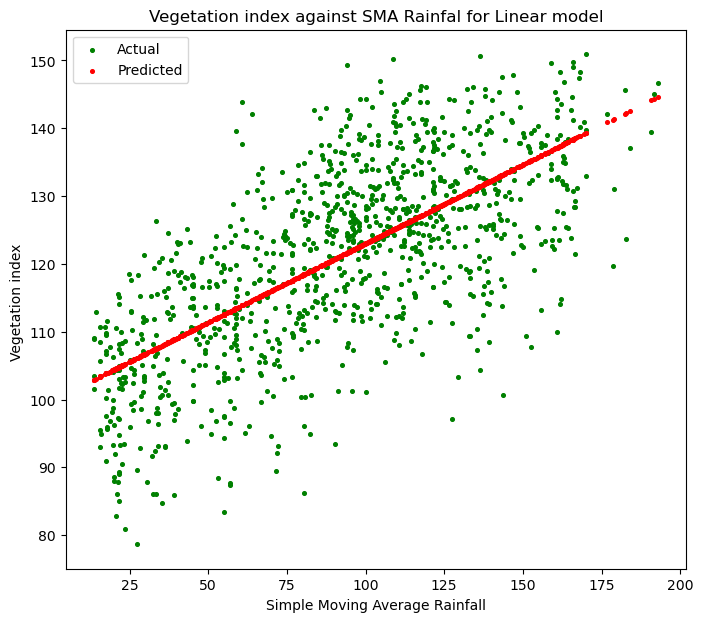

In [87]:
#plot linear model
plt.figure(figsize = (8, 7))
plt.scatter(X_test, y_test, color = 'green', s = 7, label ='Actual')
plt.scatter(X_test, linear_model_vals, color= 'red', s= 7, label ='Predicted')
plt.title('Vegetation index against SMA Rainfal for Linear model')
plt.xlabel('Simple Moving Average Rainfall')
plt.ylabel('Vegetation index ')
plt.legend()
plt.show()
    

In [88]:
#Quadratic model
optimal_quad_model = PolyModel(degree = 2)
quad_model_coeffs = np.polyfit(X_train, y_train, 2)
quad_model_vals = np.polyval(quad_model_coeffs, X_test)
r2_quad = r2_score(y_test,quad_model_vals) #evaluate quadratic model

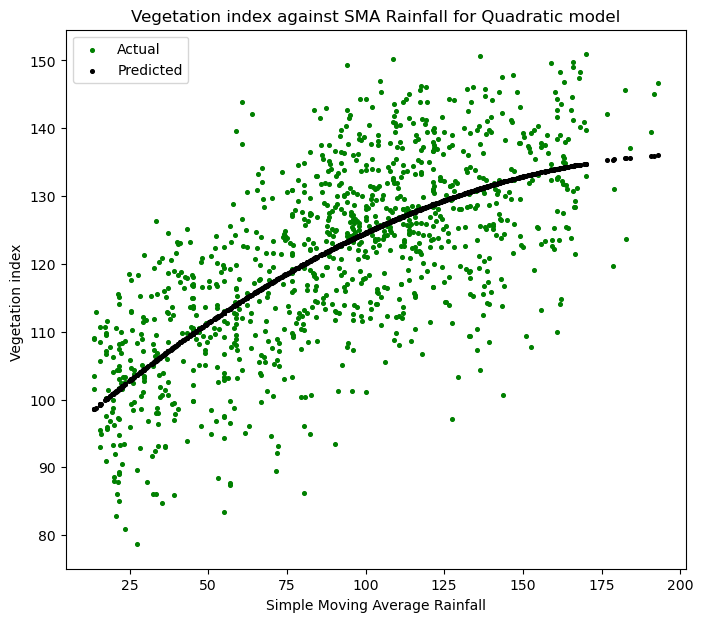

In [89]:
plt.figure(figsize = (8, 7))
plt.scatter(X_test, y_test, color = 'green', s = 7, label ='Actual')
plt.scatter(X_test,  quad_model_vals , color= 'black', s= 7, label='Predicted')
plt.title('Vegetation index against SMA Rainfall for Quadratic model')
plt.xlabel('Simple Moving Average Rainfall')
plt.ylabel('Vegetation index ')
plt.legend()
plt.show()
    

In [90]:
#Cubic model
optimal_cubic_model = PolyModel(degree = 3)
cubic_model_coeffs = np.polyfit(X_train, y_train, 3)
cubic_model_vals = np.polyval(cubic_model_coeffs, X_test )
r2_cubic = r2_score(y_test, cubic_model_vals) #evaluate cubic model

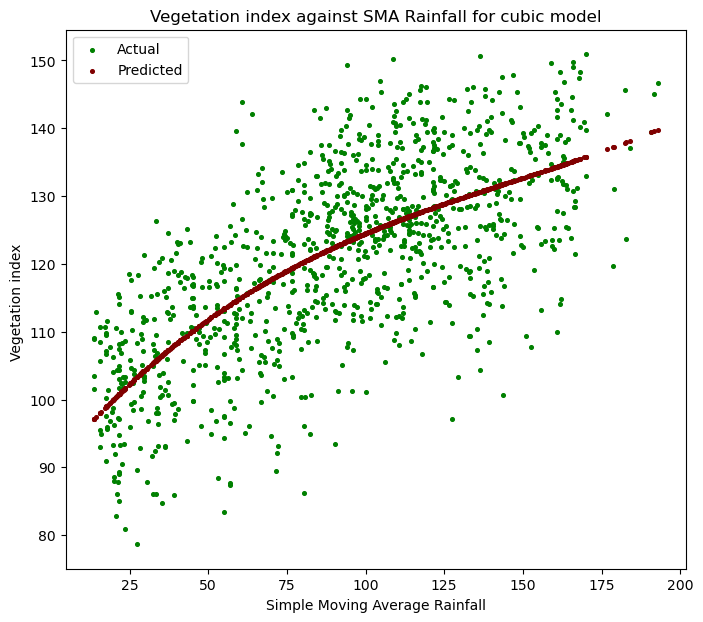

In [91]:
#Plot fitted cubic model
plt.figure(figsize = (8, 7))
plt.scatter(X_test, y_test, color = 'green', s = 7, label = 'Actual')
plt.scatter(X_test, cubic_model_vals , color= 'maroon', s = 7,label='Predicted')
plt.title('Vegetation index against SMA Rainfall for cubic model')
plt.xlabel('Simple Moving Average Rainfall')
plt.ylabel('Vegetation index ')
plt.legend()
plt.show()
    

In [92]:
#RANDOM FOREST REGRESSION MODEL
random_forest_regressor = RandomForestRegressor(random_state = 42)
random_forest_regressor.fit(X_train.reshape(-1,1), y_train)

RandomForestRegressor(random_state=42)

In [93]:
#cross validation r squared for random forest model
RFR_model_preds = random_forest_regressor.predict(X_test.reshape(-1,1))
r2_random_forest_regressor = r2_score(y_test,RFR_model_preds)
r2_random_forest_regressor

0.3743357124558314

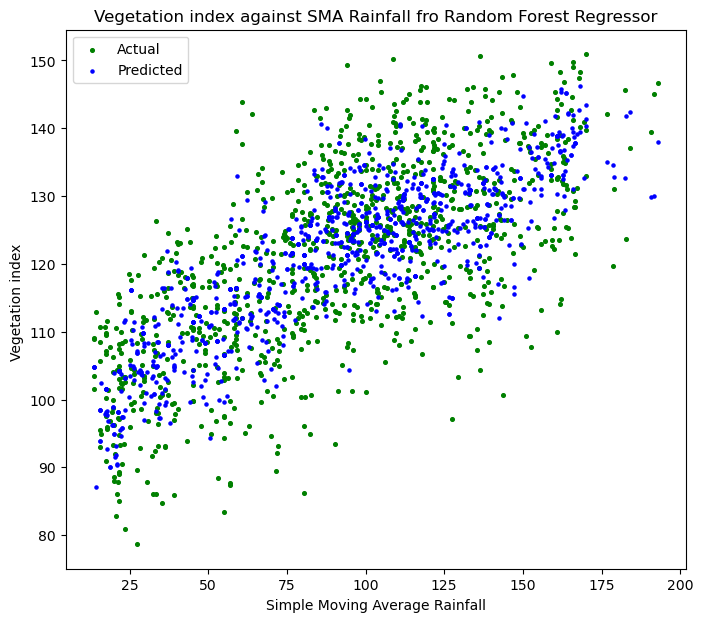

In [94]:
#plot Random Forest Regressor model

plt.figure(figsize = (8, 7))
plt.scatter(X_test, y_test, color = 'green', s = 7, label = 'Actual')
plt.title('Vegetation index against SMA Rainfall for Random Forest Regressor')
plt.scatter(X_test,RFR_model_preds , color ='blue', s = 5, label = 'Predicted')
plt.title('Vegetation index against SMA Rainfall fro Random Forest Regressor')
plt.xlabel('Simple Moving Average Rainfall')
plt.ylabel('Vegetation index ')
plt.legend()
plt.show()
    

In [95]:
#KNearest Neighbors regressor
KNN_regressor = KNeighborsRegressor()
KNN_regressor.fit(X_train.reshape(-1,1), y_train)

KNeighborsRegressor()

In [96]:
#evaluate KNN regressor
KNN_model_preds =KNN_regressor.predict(X_test.reshape(-1,1))
r2_KNN_regressor = r2_score(y_test,KNN_model_preds )
r2_KNN_regressor

0.42346655364682795

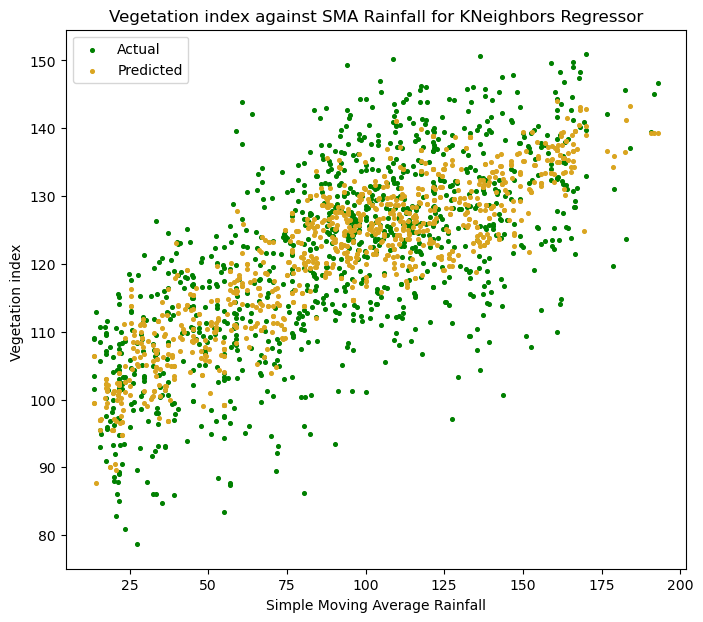

In [97]:
#plot KNN regressor model
plt.figure(figsize = (8, 7))
plt.scatter(X_test, y_test, color = 'green', s = 7, label='Actual')
plt.title('Vegetation index against SMA Rainfall for KNeighbors Regressor')
plt.scatter(X_test, KNN_model_preds, color ='goldenrod', s= 7, label ='Predicted')
plt.xlabel('Simple Moving Average Rainfall')
plt.ylabel('Vegetation index ')
plt.legend()
plt.show()
    

In [98]:
#tabulate model R-squared values
metrics = [r2_linear,r2_quad, r2_cubic,r2_random_forest_regressor,r2_KNN_regressor ]

# Initialize the delayed_SMA_metrics_ dictionary with labels as keys
labels = ['Linear', 'Quadratic', 'Cubic', 'Random Forest Regressor', 'KNeighbors Regressor']
model_metrics_ = {label: {} for label in labels}

# Update the delayed_SMA_metrics_ dictionary with the metrics
for metrics, label in zip(metrics, labels):
    model_metrics_[label]['R2 score'] = metrics


# Prepare the data for tabulatio
print(f'SMA Rainfall as a variable for vegetation index')
print('===============================================')
table_data = [[label] + list(details.values()) for label, details in model_metrics_.items()]

# Print the table using tabulate
print(tabulate(table_data, headers=["Model", "R2 score", "Adjusted R2 score", "RMSE"], tablefmt="fancy_grid"))


SMA Rainfall as a variable for vegetation index
╒═════════════════════════╤════════════╕
│ Model                   │   R2 score │
╞═════════════════════════╪════════════╡
│ Linear                  │   0.45789  │
├─────────────────────────┼────────────┤
│ Quadratic               │   0.479453 │
├─────────────────────────┼────────────┤
│ Cubic                   │   0.478627 │
├─────────────────────────┼────────────┤
│ Random Forest Regressor │   0.374336 │
├─────────────────────────┼────────────┤
│ KNeighbors Regressor    │   0.423467 │
╘═════════════════════════╧════════════╛
